Fonction à importer


In [451]:
# Core libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

# Sklearn functionality
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.tree import export_text
from sklearn import preprocessing
from sklearn import utils
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
# Keras functionality
import requests
# Ignore warnings
pd.options.mode.chained_assignment = None

Récupération des données

In [452]:
# Import data
data_stat_equipe_2023 = pd.read_html(requests.get("https://fbref.com/fr/comps/13/Statistiques-Ligue-1#stats_squads_standard_for").content)[0]
data_stat_equipe_2022 = pd.read_html(requests.get("https://fbref.com/fr/comps/13/2021-2022/Stats-2021-2022-Ligue-1#results2021-2022131_overall").content)[0]
data_stat_equipe_2021 = pd.read_html(requests.get("https://fbref.com/fr/comps/13/2020-2021/Stats-2020-2021-Ligue-1#results2020-2021131_overall").content)[0]
data_stat_equipe_2020 = pd.read_html(requests.get("https://fbref.com/fr/comps/13/2019-2020/Stats-2019-2020-Ligue-1#results2019-2020131_overall").content)[0]
data_stat_equipe_2019 = pd.read_html(requests.get("https://fbref.com/fr/comps/13/2018-2019/Stats-2018-2019-Ligue-1#results2018-2019131_overall").content)[0]
data_matchs_ligue1_2023 = pd.read_html(requests.get("https://fbref.com/fr/comps/13/calendrier/Scores-et-tableaux-Ligue-1#sched_2022-2023_13_1").content)[0]
data_matchs_ligue1_2022 = pd.read_html(requests.get("https://fbref.com/fr/comps/13/2021-2022/calendrier/Calendrier-et-resultats-2021-2022-Ligue-1#sched_all").content)[0]
data_matchs_ligue1_2021 = pd.read_html(requests.get("https://fbref.com/fr/comps/13/2020-2021/calendrier/Calendrier-et-resultats-2020-2021-Ligue-1#sched_all").content)[0]
data_matchs_ligue1_2020 = pd.read_html(requests.get("https://fbref.com/fr/comps/13/2019-2020/calendrier/Calendrier-et-resultats-2019-2020-Ligue-1#sched_2019-2020_13_1").content)[0]
data_matchs_ligue1_2019 = pd.read_html(requests.get("https://fbref.com/fr/comps/13/2018-2019/calendrier/Calendrier-et-resultats-2018-2019-Ligue-1#sched_all").content)[0]

Importer des données pour voir calculer le profit

In [453]:
# Récupération des données de pari
data_pari_2023 = pd.read_csv("pari_2023.csv")
data_pari_2022 = pd.read_csv("pari_2022.csv")
data_pari_2021 = pd.read_csv("pari_2021.csv")
data_pari_2020 = pd.read_csv("pari_2020.csv")
data_pari_2019 = pd.read_csv("pari_2019.csv")
# Concaténation des données de pari
data_pari = pd.concat([data_pari_2019,data_pari_2020,data_pari_2021,data_pari_2022,data_pari_2023],axis=0)
# Suppression des données inutiles
pari= data_pari[["B365H","B365D","B365A","Date","HomeTeam","AwayTeam"]]
# Conversion de la date en datetime
pari["Date"] =pd.to_datetime(pari["Date"],format="%d/%m/%Y")
pari["HomeTeam"].replace(["St Etienne"],"Saint-Étienne",inplace=True)
pari["AwayTeam"].replace(["St Etienne"],"Saint-Étienne",inplace=True)
pari["HomeTeam"].replace(["Paris SG"],"Paris S-G",inplace=True)
pari["AwayTeam"].replace(["Paris SG"],"Paris S-G",inplace=True)
pari["HomeTeam"].replace(["Nimes"],"Nîmes",inplace=True)
pari["AwayTeam"].replace(["Nimes"],"Nîmes",inplace=True)
pari["HomeTeam"].replace(["Clermont"],"Clermont Foot",inplace=True)

Lier les données

In [454]:
# On prend les données de 2019 à 2023
list_concat = [data_matchs_ligue1_2019,data_matchs_ligue1_2020, data_matchs_ligue1_2021, data_matchs_ligue1_2022, data_matchs_ligue1_2023]
matchs_ligue1 = pd.concat(list_concat)

Rajouter données utile 2023

In [455]:
# On copie les données pour ne pas modifier les données d'origine
matchs_ligue1_2023 = data_matchs_ligue1_2023.copy()
# On met le score sous forme de nombre
matchs_ligue1_2023["but_domicile"] = matchs_ligue1_2023["Score"].str[0]
matchs_ligue1_2023["but_exterieur"] = matchs_ligue1_2023["Score"].str[2]

# On met les points en fonction du score
matchs_ligue1_2023["Points_domicile"] = 0
matchs_ligue1_2023["Points_exterieur"] = 0
matchs_ligue1_2023.loc[matchs_ligue1_2023["but_domicile"]>matchs_ligue1_2023["but_exterieur"],"Points_domicile"] =3 
matchs_ligue1_2023.loc[matchs_ligue1_2023["but_domicile"]<matchs_ligue1_2023["but_exterieur"],"Points_exterieur"] =3
matchs_ligue1_2023.loc[matchs_ligue1_2023["but_domicile"]==matchs_ligue1_2023["but_exterieur"],["Points_domicile","Points_exterieur"]] =1
        

Créer les stats équipe pour chaque journée année 2023

In [456]:
# On crée la liste qui contiendra les statistiques de chaque équipe à chaque journée
stat_2023=[]
# On ajoute les équipes en début de saison
stat_2023.append(data_stat_equipe_2023[["Équipe", "MJ", "BM", "BE", "Pts"]])
stat_2023[0][['MJ','BM', 'BE', 'Pts',"Domicile"]] = 0
# On ajoute les statistiques de chaque équipe à chaque journée
for k in range(37):
    # On initialise la journée à l'aide de la journée précédente
    stat_2023.append(stat_2023[k].copy())
    # Le nombre de match joué augmente de 1
    stat_2023[k+1].loc[:, 'MJ'] += 1
    # On s'occupe de chaque équipe
    for i in range(len(stat_2023[k+1])):
        # On récupère les données du match de l'équipe i à la journée k+1
        donnee_match = matchs_ligue1_2023.loc[(matchs_ligue1_2023["Sem."]==k+1) & ((matchs_ligue1_2023["Domicile"]==stat_2023[k+1].loc[i, 'Équipe'])| (matchs_ligue1_2023["Extérieur"]==stat_2023[k+1].loc[i, 'Équipe']))] 
        # On vérifie si l'équipe est à domicile ou à l'extérieur
        if donnee_match.iloc[0,4]==stat_2023[k+1].loc[i, 'Équipe']:
            domicile = 1
        else:
            domicile = 0
        # On note si l'équipe est à domicile ou à l'extérieur au match k+1
        stat_2023[k].loc[i,'Domicile'] = domicile
        # On note la date du match k+1
        stat_2023[k].loc[i,"date"] = donnee_match.iloc[0,2]
        # On vérifie que le match a bien eu lieu
        if type(donnee_match.iloc[0,14]) != str:
            continue
        # On convertit les données en int
        donnee_match.iloc[0,14] = int(donnee_match.iloc[0,14])
        donnee_match.iloc[0,15] = int(donnee_match.iloc[0,15])
        donnee_match.iloc[0,16] = int(donnee_match.iloc[0,16])
        donnee_match.iloc[0,17] = int(donnee_match.iloc[0,17])
        if k == 0:
            stat_2023[k].loc[i,"Pts"] = 1.5
            stat_2023[k].loc[i,"BM"] = 1
            stat_2023[k].loc[i,"BE"] = 1
            stat_2023[k].loc[i,"Pts5"] = 1.5
            stat_2023[k].loc[i,"BM5"] = 1
            stat_2023[k].loc[i,"BE5"] = 1
            stat_2023[k].loc[i,"Pts5_save"] =str(1.5)
            stat_2023[k].loc[i,"BM5_save"] = str(1)
            stat_2023[k].loc[i,"BE5_save"] = str(1)
            if domicile:
                stat_2023[k+1].loc[i,"Pts"] = donnee_match.iloc[0,16]
                stat_2023[k+1].loc[i,"BM"] = donnee_match.iloc[0,14]
                stat_2023[k+1].loc[i,"BE"] = donnee_match.iloc[0,15]
                stat_2023[k+1].loc[i,"Pts5"] = donnee_match.iloc[0,16]
                stat_2023[k+1].loc[i,"BM5"] = donnee_match.iloc[0,14]
                stat_2023[k+1].loc[i,"BE5"] = donnee_match.iloc[0,15]
                stat_2023[k+1].loc[i,"Pts5_save"] =str(donnee_match.iloc[0,16])
                stat_2023[k+1].loc[i,"BM5_save"] = str(donnee_match.iloc[0,14])
                stat_2023[k+1].loc[i,"BE5_save"] = str(donnee_match.iloc[0,15])         
            else:
                stat_2023[k+1].loc[i,"Pts"] = donnee_match.iloc[0,17]
                stat_2023[k+1].loc[i,"BM"] = donnee_match.iloc[0,15]
                stat_2023[k+1].loc[i,"BE"] = donnee_match.iloc[0,14]
                stat_2023[k+1].loc[i,"Pts5"] = donnee_match.iloc[0,17]
                stat_2023[k+1].loc[i,"BM5"] = donnee_match.iloc[0,15]
                stat_2023[k+1].loc[i,"BE5"] = donnee_match.iloc[0,14]
                stat_2023[k+1].loc[i,"Pts5_save"] = str(donnee_match.iloc[0,17])
                stat_2023[k+1].loc[i,"BM5_save"] = str(donnee_match.iloc[0,15])
                stat_2023[k+1].loc[i,"BE5_save"] = str(donnee_match.iloc[0,14])
            continue
        if domicile:
            stat_2023[k+1].loc[i,"Pts"] =(k*stat_2023[k+1].loc[i,"Pts"] + donnee_match.iloc[0,16])/(k+1)
            stat_2023[k+1].loc[i,"BM"] = (k*stat_2023[k+1].loc[i,"BM"] + donnee_match.iloc[0,14])/ (k+1)
            stat_2023[k+1].loc[i,"BE"] = (k*stat_2023[k+1].loc[i,"BE"] + donnee_match.iloc[0,15])/ (k+1)
            if k<5:
                stat_2023[k+1].loc[i,"Pts5"] =(k*stat_2023[k+1].loc[i,"Pts5"] + donnee_match.iloc[0,16])/(k+1)
                stat_2023[k+1].loc[i,"BM5"] = (k*stat_2023[k+1].loc[i,"BM5"] + donnee_match.iloc[0,14])/ (k+1)
                stat_2023[k+1].loc[i,"BE5"] = (k*stat_2023[k+1].loc[i,"BE5"] + donnee_match.iloc[0,15])/ (k+1)
                stat_2023[k+1].loc[i,"Pts5_save"]+= str(donnee_match.iloc[0,16])
                stat_2023[k+1].loc[i,"BM5_save"]+= str(donnee_match.iloc[0,14])
                stat_2023[k+1].loc[i,"BE5_save"]+= str(donnee_match.iloc[0,15])
            else:
                stat_2023[k+1].loc[i,"Pts5"] =(5*stat_2023[k+1].loc[i,"Pts5"]- int(stat_2023[k+1].loc[i,"Pts5_save"][0]) + donnee_match.iloc[0,16] )/5
                stat_2023[k+1].loc[i,"BM5"] = (5*stat_2023[k+1].loc[i,"BM5"]- int(stat_2023[k+1].loc[i,"BM5_save"][0]) + donnee_match.iloc[0,14] )/5
                stat_2023[k+1].loc[i,"BE5"] = (5*stat_2023[k+1].loc[i,"BE5"]- int(stat_2023[k+1].loc[i,"BE5_save"][0]) + donnee_match.iloc[0,15] )/5
                stat_2023[k+1].loc[i,"Pts5_save"] = stat_2023[k+1].loc[i,"Pts5_save"][1:]
                stat_2023[k+1].loc[i,"BM5_save"] = stat_2023[k+1].loc[i,"BM5_save"][1:]
                stat_2023[k+1].loc[i,"BE5_save"] = stat_2023[k+1].loc[i,"BE5_save"][1:]
                stat_2023[k+1].loc[i,"Pts5_save"]+= str(donnee_match.iloc[0,16])
                stat_2023[k+1].loc[i,"BM5_save"]+= str(donnee_match.iloc[0,14])
                stat_2023[k+1].loc[i,"BE5_save"]+= str(donnee_match.iloc[0,15])
        else:
            stat_2023[k+1].loc[i,"Pts"] =(k*stat_2023[k+1].loc[i,"Pts"] + donnee_match.iloc[0,17])/(k+1)
            stat_2023[k+1].loc[i,"BM"] = (k*stat_2023[k+1].loc[i,"BM"] + donnee_match.iloc[0,15])/ (k+1)
            stat_2023[k+1].loc[i,"BE"] = (k*stat_2023[k+1].loc[i,"BE"] + donnee_match.iloc[0,14])/ (k+1)
            if k<5:
                stat_2023[k+1].loc[i,"Pts5"] =(k*stat_2023[k+1].loc[i,"Pts5"] + donnee_match.iloc[0,17])/(k+1)
                stat_2023[k+1].loc[i,"BM5"] = (k*stat_2023[k+1].loc[i,"BM5"] + donnee_match.iloc[0,15])/ (k+1)
                stat_2023[k+1].loc[i,"BE5"] = (k*stat_2023[k+1].loc[i,"BE5"] + donnee_match.iloc[0,14])/ (k+1)
                stat_2023[k+1].loc[i,"Pts5_save"]+= str(donnee_match.iloc[0,17])
                stat_2023[k+1].loc[i,"BM5_save"]+= str(donnee_match.iloc[0,15])
                stat_2023[k+1].loc[i,"BE5_save"]+= str(donnee_match.iloc[0,14])
            else:
                stat_2023[k+1].loc[i,"Pts5"] =(5*stat_2023[k+1].loc[i,"Pts5"]- int(stat_2023[k+1].loc[i,"Pts5_save"][0]) + donnee_match.iloc[0,17] )/5
                stat_2023[k+1].loc[i,"BM5"] = (5*stat_2023[k+1].loc[i,"BM5"]- int(stat_2023[k+1].loc[i,"BM5_save"][0]) + donnee_match.iloc[0,15] )/5
                stat_2023[k+1].loc[i,"BE5"] = (5*stat_2023[k+1].loc[i,"BE5"]- int(stat_2023[k+1].loc[i,"BE5_save"][0]) + donnee_match.iloc[0,14] )/5
                stat_2023[k+1].loc[i,"Pts5_save"] = stat_2023[k+1].loc[i,"Pts5_save"][1:]
                stat_2023[k+1].loc[i,"BM5_save"] = stat_2023[k+1].loc[i,"BM5_save"][1:]
                stat_2023[k+1].loc[i,"BE5_save"] = stat_2023[k+1].loc[i,"BE5_save"][1:]
                stat_2023[k+1].loc[i,"Pts5_save"]+= str(donnee_match.iloc[0,17])
                stat_2023[k+1].loc[i,"BM5_save"]+= str(donnee_match.iloc[0,15]) 
                stat_2023[k+1].loc[i,"BE5_save"]+= str(donnee_match.iloc[0,14]) 
    # On trie les équipes par points moyens
    stat_2023[k+1].sort_values(by=['Pts'], ascending=False, inplace=True)
    # On réinitialise l'index
    stat_2023[k+1].reset_index(drop=True, inplace=True)
# On concatène les statistiques de chaque journée    
stats_2023 = pd.concat(stat_2023)


Pareille année 2022

In [457]:
#Clean année 2022
# # On copie les données pour ne pas modifier les données d'origine
matchs_ligue1_2022 = data_matchs_ligue1_2022.copy()
# On enlève les matchs de barrages
matchs_ligue1_2022 = matchs_ligue1_2022[matchs_ligue1_2022["Tour"] != "Barrage 1/2 Relégation/Promotion France"]
# On enlève la colonne Tour
matchs_ligue1_2022.drop(columns="Tour", inplace=True)
matchs_ligue1_2022["but_domicile"] = matchs_ligue1_2022["Score"].str[0]
matchs_ligue1_2022["but_exterieur"] = matchs_ligue1_2022["Score"].str[2]
matchs_ligue1_2022["Points_domicile"] = 0
matchs_ligue1_2022["Points_exterieur"] = 0
matchs_ligue1_2022.loc[matchs_ligue1_2022["but_domicile"]>matchs_ligue1_2022["but_exterieur"],"Points_domicile"] =3 
matchs_ligue1_2022.loc[matchs_ligue1_2022["but_domicile"]<matchs_ligue1_2022["but_exterieur"],"Points_exterieur"] =3
matchs_ligue1_2022.loc[matchs_ligue1_2022["but_domicile"]==matchs_ligue1_2022["but_exterieur"],["Points_domicile","Points_exterieur"]] =1
stat_2022=[]
stat_2022.append(data_stat_equipe_2022[["Équipe", "MJ", "BM", "BE", "Pts"]])
stat_2022[0][['MJ','BM', 'BE', 'Pts',"Domicile","BM5","BE5","Pts5"]] = 0
stat_2022[0][["BM5_save","BE5_save","Pts5_save"]] = ""
for k in range(37):
    stat_2022.append(stat_2022[k].copy())
    stat_2022[k+1].loc[:, 'MJ'] += 1
    for i in range(len(stat_2022[k+1])):
        donnee_match = matchs_ligue1_2022.loc[(matchs_ligue1_2022["Sem."]==k+1) & ((matchs_ligue1_2022["Domicile"]==stat_2022[k+1].loc[i, 'Équipe'])| (matchs_ligue1_2022["Extérieur"]==stat_2022[k+1].loc[i, 'Équipe']))] 
        if donnee_match.iloc[0,4]==stat_2022[k+1].loc[i,'Équipe']:
            domicile = 1
        else:
            domicile = 0
        stat_2022[k].loc[i,'Domicile'] = domicile
        stat_2022[k].loc[i,"date"] = donnee_match.iloc[0,2]
        if type(donnee_match.iloc[0,14]) != str:
            continue
        donnee_match.iloc[0,14] = int(donnee_match.iloc[0,14])
        donnee_match.iloc[0,15] = int(donnee_match.iloc[0,15])
        donnee_match.iloc[0,16] = int(donnee_match.iloc[0,16])
        donnee_match.iloc[0,17] = int(donnee_match.iloc[0,17])
        if k == 0:
            stat_2022[k].loc[i,"Pts"] = 1.5
            stat_2022[k].loc[i,"BM"] = 1
            stat_2022[k].loc[i,"BE"] = 1
            stat_2022[k].loc[i,"Pts5"] = 1.5
            stat_2022[k].loc[i,"BM5"] = 1
            stat_2022[k].loc[i,"BE5"] = 1
            stat_2022[k].loc[i,"Pts5_save"] =str(1.5)
            stat_2022[k].loc[i,"BM5_save"] = str(1)
            stat_2022[k].loc[i,"BE5_save"] = str(1)
            if domicile:
                stat_2022[k+1].loc[i,"Pts"] = donnee_match.iloc[0,16]
                stat_2022[k+1].loc[i,"BM"] = donnee_match.iloc[0,14]
                stat_2022[k+1].loc[i,"BE"] = donnee_match.iloc[0,15]
                stat_2022[k+1].loc[i,"Pts5"] = donnee_match.iloc[0,16]
                stat_2022[k+1].loc[i,"BM5"] = donnee_match.iloc[0,14]
                stat_2022[k+1].loc[i,"BE5"] = donnee_match.iloc[0,15]
                stat_2022[k+1].loc[i,"Pts5_save"] =str(donnee_match.iloc[0,16])
                stat_2022[k+1].loc[i,"BM5_save"] = str(donnee_match.iloc[0,14])
                stat_2022[k+1].loc[i,"BE5_save"] = str(donnee_match.iloc[0,15])         
            else:
                stat_2022[k+1].loc[i,"Pts"] = donnee_match.iloc[0,17]
                stat_2022[k+1].loc[i,"BM"] = donnee_match.iloc[0,15]
                stat_2022[k+1].loc[i,"BE"] = donnee_match.iloc[0,14]
                stat_2022[k+1].loc[i,"Pts5"] = donnee_match.iloc[0,17]
                stat_2022[k+1].loc[i,"BM5"] = donnee_match.iloc[0,15]
                stat_2022[k+1].loc[i,"BE5"] = donnee_match.iloc[0,14]
                stat_2022[k+1].loc[i,"Pts5_save"] = str(donnee_match.iloc[0,17])
                stat_2022[k+1].loc[i,"BM5_save"] = str(donnee_match.iloc[0,15])
                stat_2022[k+1].loc[i,"BE5_save"] = str(donnee_match.iloc[0,14])
            continue
        if domicile:
            stat_2022[k+1].loc[i,"Pts"] =(k*stat_2022[k+1].loc[i,"Pts"] + donnee_match.iloc[0,16])/(k+1)
            stat_2022[k+1].loc[i,"BM"] = (k*stat_2022[k+1].loc[i,"BM"] + donnee_match.iloc[0,14])/ (k+1)
            stat_2022[k+1].loc[i,"BE"] = (k*stat_2022[k+1].loc[i,"BE"] + donnee_match.iloc[0,15])/ (k+1)
            if k<5:
                stat_2022[k+1].loc[i,"Pts5"] =(k*stat_2022[k+1].loc[i,"Pts5"] + donnee_match.iloc[0,16])/(k+1)
                stat_2022[k+1].loc[i,"BM5"] = (k*stat_2022[k+1].loc[i,"BM5"] + donnee_match.iloc[0,14])/ (k+1)
                stat_2022[k+1].loc[i,"BE5"] = (k*stat_2022[k+1].loc[i,"BE5"] + donnee_match.iloc[0,15])/ (k+1)
                stat_2022[k+1].loc[i,"Pts5_save"]+= str(donnee_match.iloc[0,16])
                stat_2022[k+1].loc[i,"BM5_save"]+= str(donnee_match.iloc[0,14])
                stat_2022[k+1].loc[i,"BE5_save"]+= str(donnee_match.iloc[0,15])
            else:
                stat_2022[k+1].loc[i,"Pts5"] =(5*stat_2022[k+1].loc[i,"Pts5"]- int(stat_2022[k+1].loc[i,"Pts5_save"][0]) + donnee_match.iloc[0,16] )/5
                stat_2022[k+1].loc[i,"BM5"] = (5*stat_2022[k+1].loc[i,"BM5"]- int(stat_2022[k+1].loc[i,"BM5_save"][0]) + donnee_match.iloc[0,14] )/5
                stat_2022[k+1].loc[i,"BE5"] = (5*stat_2022[k+1].loc[i,"BE5"]- int(stat_2022[k+1].loc[i,"BE5_save"][0]) + donnee_match.iloc[0,15] )/5
                stat_2022[k+1].loc[i,"Pts5_save"] = stat_2022[k+1].loc[i,"Pts5_save"][1:]
                stat_2022[k+1].loc[i,"BM5_save"] = stat_2022[k+1].loc[i,"BM5_save"][1:]
                stat_2022[k+1].loc[i,"BE5_save"] = stat_2022[k+1].loc[i,"BE5_save"][1:]
                stat_2022[k+1].loc[i,"Pts5_save"]+= str(donnee_match.iloc[0,16])
                stat_2022[k+1].loc[i,"BM5_save"]+= str(donnee_match.iloc[0,14])
                stat_2022[k+1].loc[i,"BE5_save"]+= str(donnee_match.iloc[0,15])
        else:
            stat_2022[k+1].loc[i,"Pts"] =(k*stat_2022[k+1].loc[i,"Pts"] + donnee_match.iloc[0,17])/(k+1)
            stat_2022[k+1].loc[i,"BM"] = (k*stat_2022[k+1].loc[i,"BM"] + donnee_match.iloc[0,15])/ (k+1)
            stat_2022[k+1].loc[i,"BE"] = (k*stat_2022[k+1].loc[i,"BE"] + donnee_match.iloc[0,14])/ (k+1)
            if k<5:
                stat_2022[k+1].loc[i,"Pts5"] =(k*stat_2022[k+1].loc[i,"Pts5"] + donnee_match.iloc[0,17])/(k+1)
                stat_2022[k+1].loc[i,"BM5"] = (k*stat_2022[k+1].loc[i,"BM5"] + donnee_match.iloc[0,15])/ (k+1)
                stat_2022[k+1].loc[i,"BE5"] = (k*stat_2022[k+1].loc[i,"BE5"] + donnee_match.iloc[0,14])/ (k+1)
                stat_2022[k+1].loc[i,"Pts5_save"]+= str(donnee_match.iloc[0,17])
                stat_2022[k+1].loc[i,"BM5_save"]+= str(donnee_match.iloc[0,15])
                stat_2022[k+1].loc[i,"BE5_save"]+= str(donnee_match.iloc[0,14])    
            else:
                stat_2022[k+1].loc[i,"Pts5"] =(5*stat_2022[k+1].loc[i,"Pts5"]- int(stat_2022[k+1].loc[i,"Pts5_save"][0]) + donnee_match.iloc[0,17] )/5
                stat_2022[k+1].loc[i,"BM5"] = (5*stat_2022[k+1].loc[i,"BM5"]- int(stat_2022[k+1].loc[i,"BM5_save"][0]) + donnee_match.iloc[0,15] )/5
                stat_2022[k+1].loc[i,"BE5"] = (5*stat_2022[k+1].loc[i,"BE5"]- int(stat_2022[k+1].loc[i,"BE5_save"][0]) + donnee_match.iloc[0,14] )/5
                stat_2022[k+1].loc[i,"Pts5_save"] = stat_2022[k+1].loc[i,"Pts5_save"][1:]
                stat_2022[k+1].loc[i,"BM5_save"] = stat_2022[k+1].loc[i,"BM5_save"][1:]
                stat_2022[k+1].loc[i,"BE5_save"] = stat_2022[k+1].loc[i,"BE5_save"][1:]
                stat_2022[k+1].loc[i,"Pts5_save"]+= str(donnee_match.iloc[0,17])
                stat_2022[k+1].loc[i,"BM5_save"]+= str(donnee_match.iloc[0,15])
                stat_2022[k+1].loc[i,"BE5_save"]+= str(donnee_match.iloc[0,14])   
    stat_2022[k+1].sort_values(by=['Pts'], ascending=False, inplace=True)
    stat_2022[k+1].reset_index(drop=True, inplace=True)
stats_2022 = pd.concat(stat_2022)

Année 2021

In [458]:
#Clean année 2021
# On copie les données pour ne pas modifier les données d'origine
matchs_ligue1_2021 = data_matchs_ligue1_2021.copy()
matchs_ligue1_2021 = matchs_ligue1_2021[matchs_ligue1_2021["Tour"] != "Barrage 1/2 Relégation/Promotion France"]
matchs_ligue1_2021.drop(columns="Tour", inplace=True)
matchs_ligue1_2021["but_domicile"] = matchs_ligue1_2021["Score"].str[0]
matchs_ligue1_2021["but_exterieur"] = matchs_ligue1_2021["Score"].str[2]
matchs_ligue1_2021["Points_domicile"] = 0
matchs_ligue1_2021["Points_exterieur"] = 0
matchs_ligue1_2021.loc[matchs_ligue1_2021["but_domicile"]>matchs_ligue1_2021["but_exterieur"],"Points_domicile"] =3 
matchs_ligue1_2021.loc[matchs_ligue1_2021["but_domicile"]<matchs_ligue1_2021["but_exterieur"],"Points_exterieur"] =3
matchs_ligue1_2021.loc[matchs_ligue1_2021["but_domicile"]==matchs_ligue1_2021["but_exterieur"],["Points_domicile","Points_exterieur"]] =1

stat_2021=[]
stat_2021.append(data_stat_equipe_2021[["Équipe", "MJ", "BM", "BE", "Pts"]])
stat_2021[0][['MJ','BM', 'BE', 'Pts',"Domicile"]] = 0
for k in range(37):
    stat_2021.append(stat_2021[k].copy())
    stat_2021[k+1].loc[:, 'MJ'] += 1
    for i in range(len(stat_2021[k+1])):
        donnee_match = matchs_ligue1_2021.loc[(matchs_ligue1_2021["Sem."]==k+1) & ((matchs_ligue1_2021["Domicile"]==stat_2021[k+1].loc[i, 'Équipe'])| (matchs_ligue1_2021["Extérieur"]==stat_2021[k+1].loc[i, 'Équipe']))] 
        if donnee_match.iloc[0,4]==stat_2021[k+1].loc[i, 'Équipe']:
            domicile = 1
        else:
            domicile = 0
        stat_2021[k].loc[i,'Domicile'] = domicile
        stat_2021[k].loc[i,"date"] = donnee_match.iloc[0,2]
        if type(donnee_match.iloc[0,14]) != str:
            continue
        donnee_match.iloc[0,14] = int(donnee_match.iloc[0,14])
        donnee_match.iloc[0,15] = int(donnee_match.iloc[0,15])
        donnee_match.iloc[0,16] = int(donnee_match.iloc[0,16])
        donnee_match.iloc[0,17] = int(donnee_match.iloc[0,17])
        if k == 0:
            stat_2021[k].loc[i,"Pts"] = 1.5
            stat_2021[k].loc[i,"BM"] = 1
            stat_2021[k].loc[i,"BE"] = 1
            stat_2021[k].loc[i,"Pts5"] = 1.5
            stat_2021[k].loc[i,"BM5"] = 1
            stat_2021[k].loc[i,"BE5"] = 1
            stat_2021[k].loc[i,"Pts5_save"] =str(1.5)
            stat_2021[k].loc[i,"BM5_save"] = str(1)
            stat_2021[k].loc[i,"BE5_save"] = str(1)
            if domicile:
                stat_2021[k+1].loc[i,"Pts"] = donnee_match.iloc[0,16]
                stat_2021[k+1].loc[i,"BM"] = donnee_match.iloc[0,14]
                stat_2021[k+1].loc[i,"BE"] = donnee_match.iloc[0,15]
                stat_2021[k+1].loc[i,"Pts5"] = donnee_match.iloc[0,16]
                stat_2021[k+1].loc[i,"BM5"] = donnee_match.iloc[0,14]
                stat_2021[k+1].loc[i,"BE5"] = donnee_match.iloc[0,15]
                stat_2021[k+1].loc[i,"Pts5_save"] =str(donnee_match.iloc[0,16])
                stat_2021[k+1].loc[i,"BM5_save"] = str(donnee_match.iloc[0,14])
                stat_2021[k+1].loc[i,"BE5_save"] = str(donnee_match.iloc[0,15])         
            else:
                stat_2021[k+1].loc[i,"Pts"] = donnee_match.iloc[0,17]
                stat_2021[k+1].loc[i,"BM"] = donnee_match.iloc[0,15]
                stat_2021[k+1].loc[i,"BE"] = donnee_match.iloc[0,14]
                stat_2021[k+1].loc[i,"Pts5"] = donnee_match.iloc[0,17]
                stat_2021[k+1].loc[i,"BM5"] = donnee_match.iloc[0,15]
                stat_2021[k+1].loc[i,"BE5"] = donnee_match.iloc[0,14]
                stat_2021[k+1].loc[i,"Pts5_save"] = str(donnee_match.iloc[0,17])
                stat_2021[k+1].loc[i,"BM5_save"] = str(donnee_match.iloc[0,15])
                stat_2021[k+1].loc[i,"BE5_save"] = str(donnee_match.iloc[0,14])
            continue
        if domicile:
            stat_2021[k+1].loc[i,"Pts"] =(k*stat_2021[k+1].loc[i,"Pts"] + donnee_match.iloc[0,16])/(k+1)
            stat_2021[k+1].loc[i,"BM"] = (k*stat_2021[k+1].loc[i,"BM"] + donnee_match.iloc[0,14])/ (k+1)
            stat_2021[k+1].loc[i,"BE"] = (k*stat_2021[k+1].loc[i,"BE"] + donnee_match.iloc[0,15])/ (k+1)
            if k<5:
                stat_2021[k+1].loc[i,"Pts5"] =(k*stat_2021[k+1].loc[i,"Pts5"] + donnee_match.iloc[0,16])/(k+1)
                stat_2021[k+1].loc[i,"BM5"] = (k*stat_2021[k+1].loc[i,"BM5"] + donnee_match.iloc[0,14])/ (k+1)
                stat_2021[k+1].loc[i,"BE5"] = (k*stat_2021[k+1].loc[i,"BE5"] + donnee_match.iloc[0,15])/ (k+1)
                stat_2021[k+1].loc[i,"Pts5_save"]+= str(donnee_match.iloc[0,16])
                stat_2021[k+1].loc[i,"BM5_save"]+= str(donnee_match.iloc[0,14])
                stat_2021[k+1].loc[i,"BE5_save"]+= str(donnee_match.iloc[0,15])
            else:
                stat_2021[k+1].loc[i,"Pts5"] =(5*stat_2021[k+1].loc[i,"Pts5"]- int(stat_2021[k+1].loc[i,"Pts5_save"][0]) + donnee_match.iloc[0,16] )/5
                stat_2021[k+1].loc[i,"BM5"] = (5*stat_2021[k+1].loc[i,"BM5"]- int(stat_2021[k+1].loc[i,"BM5_save"][0]) + donnee_match.iloc[0,14] )/5
                stat_2021[k+1].loc[i,"BE5"] = (5*stat_2021[k+1].loc[i,"BE5"]- int(stat_2021[k+1].loc[i,"BE5_save"][0]) + donnee_match.iloc[0,15] )/5
                stat_2021[k+1].loc[i,"Pts5_save"] = stat_2021[k+1].loc[i,"Pts5_save"][1:]
                stat_2021[k+1].loc[i,"BM5_save"] = stat_2021[k+1].loc[i,"BM5_save"][1:]
                stat_2021[k+1].loc[i,"BE5_save"] = stat_2021[k+1].loc[i,"BE5_save"][1:]
                stat_2021[k+1].loc[i,"Pts5_save"]+= str(donnee_match.iloc[0,16])
                stat_2021[k+1].loc[i,"BM5_save"]+= str(donnee_match.iloc[0,14])
                stat_2021[k+1].loc[i,"BE5_save"]+= str(donnee_match.iloc[0,15])
        else:
            stat_2021[k+1].loc[i,"Pts"] =(k*stat_2021[k+1].loc[i,"Pts"] + donnee_match.iloc[0,17])/(k+1)
            stat_2021[k+1].loc[i,"BM"] = (k*stat_2021[k+1].loc[i,"BM"] + donnee_match.iloc[0,15])/ (k+1)
            stat_2021[k+1].loc[i,"BE"] = (k*stat_2021[k+1].loc[i,"BE"] + donnee_match.iloc[0,14])/ (k+1)
            if k<5:
                stat_2021[k+1].loc[i,"Pts5"] =(k*stat_2021[k+1].loc[i,"Pts5"] + donnee_match.iloc[0,17])/(k+1)
                stat_2021[k+1].loc[i,"BM5"] = (k*stat_2021[k+1].loc[i,"BM5"] + donnee_match.iloc[0,15])/ (k+1)
                stat_2021[k+1].loc[i,"BE5"] = (k*stat_2021[k+1].loc[i,"BE5"] + donnee_match.iloc[0,14])/ (k+1)
                stat_2021[k+1].loc[i,"Pts5_save"]+= str(donnee_match.iloc[0,17])
                stat_2021[k+1].loc[i,"BM5_save"]+= str(donnee_match.iloc[0,15])
                stat_2021[k+1].loc[i,"BE5_save"]+= str(donnee_match.iloc[0,14])
            else:
                stat_2021[k+1].loc[i,"Pts5"] =(5*stat_2021[k+1].loc[i,"Pts5"]- int(stat_2021[k+1].loc[i,"Pts5_save"][0]) + donnee_match.iloc[0,17] )/5
                stat_2021[k+1].loc[i,"BM5"] = (5*stat_2021[k+1].loc[i,"BM5"]- int(stat_2021[k+1].loc[i,"BM5_save"][0]) + donnee_match.iloc[0,15] )/5
                stat_2021[k+1].loc[i,"BE5"] = (5*stat_2021[k+1].loc[i,"BE5"]- int(stat_2021[k+1].loc[i,"BE5_save"][0]) + donnee_match.iloc[0,14] )/5
                stat_2021[k+1].loc[i,"Pts5_save"] = stat_2021[k+1].loc[i,"Pts5_save"][1:]
                stat_2021[k+1].loc[i,"BM5_save"] = stat_2021[k+1].loc[i,"BM5_save"][1:]
                stat_2021[k+1].loc[i,"BE5_save"] = stat_2021[k+1].loc[i,"BE5_save"][1:]
                stat_2021[k+1].loc[i,"Pts5_save"]+= str(donnee_match.iloc[0,17])
                stat_2021[k+1].loc[i,"BM5_save"]+= str(donnee_match.iloc[0,15])
                stat_2021[k+1].loc[i,"BE5_save"]+= str(donnee_match.iloc[0,14])
    stat_2021[k+1].sort_values(by=['Pts'], ascending=False, inplace=True)
    stat_2021[k+1].reset_index(drop=True, inplace=True)  
stats_2021 = pd.concat(stat_2021)

Année 2020

In [459]:
#Clean année 2020
# On copie les données pour ne pas modifier les données d'origine
matchs_ligue1_2020 = data_matchs_ligue1_2020.copy()
matchs_ligue1_2020["but_domicile"] = matchs_ligue1_2020["Score"].str[0]
matchs_ligue1_2020["but_exterieur"] = matchs_ligue1_2020["Score"].str[2]
matchs_ligue1_2020["Points_domicile"] = 0
matchs_ligue1_2020["Points_exterieur"] = 0
matchs_ligue1_2020.loc[matchs_ligue1_2020["but_domicile"]>matchs_ligue1_2020["but_exterieur"],"Points_domicile"] =3 
matchs_ligue1_2020.loc[matchs_ligue1_2020["but_domicile"]<matchs_ligue1_2020["but_exterieur"],"Points_exterieur"] =3
matchs_ligue1_2020.loc[matchs_ligue1_2020["but_domicile"]==matchs_ligue1_2020["but_exterieur"],["Points_domicile","Points_exterieur"]] =1

stat_2020=[]
stat_2020.append(data_stat_equipe_2020[["Équipe", "MJ", "BM", "BE", "Pts"]])
stat_2020[0][['MJ','BM', 'BE', 'Pts',"Domicile"]] = 0
for k in range(38):
    stat_2020.append(stat_2020[k].copy())
    stat_2020[k+1].loc[:, 'MJ'] += 1
    for i in range(len(stat_2020[k+1])):
        donnee_match = matchs_ligue1_2020.loc[(matchs_ligue1_2020["Sem."]==k+1) & ((matchs_ligue1_2020["Domicile"]==stat_2020[k+1].loc[i, 'Équipe'])| (matchs_ligue1_2020["Extérieur"]==stat_2020[k+1].loc[i, 'Équipe']))] 
        if donnee_match.iloc[0,4]==stat_2020[k+1].loc[i, 'Équipe']:
            domicile = 1
        else:
            domicile = 0
        stat_2020[k].loc[i,'Domicile'] = domicile
        stat_2020[k].loc[i,"date"] = donnee_match.iloc[0,2]
        if type(donnee_match.iloc[0,14]) != str:
            continue
        donnee_match.iloc[0,14] = int(donnee_match.iloc[0,14])
        donnee_match.iloc[0,15] = int(donnee_match.iloc[0,15])
        donnee_match.iloc[0,16] = int(donnee_match.iloc[0,16])
        donnee_match.iloc[0,17] = int(donnee_match.iloc[0,17])
        if k == 0:
            stat_2020[k].loc[i,"Pts"] = 1.5
            stat_2020[k].loc[i,"BM"] = 1
            stat_2020[k].loc[i,"BE"] = 1
            stat_2020[k].loc[i,"Pts5"] = 1.5
            stat_2020[k].loc[i,"BM5"] = 1
            stat_2020[k].loc[i,"BE5"] = 1
            stat_2020[k].loc[i,"Pts5_save"] =str(1.5)
            stat_2020[k].loc[i,"BM5_save"] = str(1)
            stat_2020[k].loc[i,"BE5_save"] = str(1)
            if domicile:
                stat_2020[k+1].loc[i,"Pts"] = donnee_match.iloc[0,16]
                stat_2020[k+1].loc[i,"BM"] = donnee_match.iloc[0,14]
                stat_2020[k+1].loc[i,"BE"] = donnee_match.iloc[0,15]
                stat_2020[k+1].loc[i,"Pts5"] = donnee_match.iloc[0,16]
                stat_2020[k+1].loc[i,"BM5"] = donnee_match.iloc[0,14]
                stat_2020[k+1].loc[i,"BE5"] = donnee_match.iloc[0,15]
                stat_2020[k+1].loc[i,"Pts5_save"] =str(donnee_match.iloc[0,16])
                stat_2020[k+1].loc[i,"BM5_save"] = str(donnee_match.iloc[0,14])
                stat_2020[k+1].loc[i,"BE5_save"] = str(donnee_match.iloc[0,15])         
            else:
                stat_2020[k+1].loc[i,"Pts"] = donnee_match.iloc[0,17]
                stat_2020[k+1].loc[i,"BM"] = donnee_match.iloc[0,15]
                stat_2020[k+1].loc[i,"BE"] = donnee_match.iloc[0,14]
                stat_2020[k+1].loc[i,"Pts5"] = donnee_match.iloc[0,17]
                stat_2020[k+1].loc[i,"BM5"] = donnee_match.iloc[0,15]
                stat_2020[k+1].loc[i,"BE5"] = donnee_match.iloc[0,14]
                stat_2020[k+1].loc[i,"Pts5_save"] = str(donnee_match.iloc[0,17])
                stat_2020[k+1].loc[i,"BM5_save"] = str(donnee_match.iloc[0,15])
                stat_2020[k+1].loc[i,"BE5_save"] = str(donnee_match.iloc[0,14])
            continue
        if domicile:
            stat_2020[k+1].loc[i,"Pts"] =(k*stat_2020[k+1].loc[i,"Pts"] + donnee_match.iloc[0,16])/(k+1)
            stat_2020[k+1].loc[i,"BM"] = (k*stat_2020[k+1].loc[i,"BM"] + donnee_match.iloc[0,14])/ (k+1)
            stat_2020[k+1].loc[i,"BE"] = (k*stat_2020[k+1].loc[i,"BE"] + donnee_match.iloc[0,15])/ (k+1)
            if k<5:
                stat_2020[k+1].loc[i,"Pts5"] =(k*stat_2020[k+1].loc[i,"Pts5"] + donnee_match.iloc[0,16])/(k+1)
                stat_2020[k+1].loc[i,"BM5"] = (k*stat_2020[k+1].loc[i,"BM5"] + donnee_match.iloc[0,14])/ (k+1)
                stat_2020[k+1].loc[i,"BE5"] = (k*stat_2020[k+1].loc[i,"BE5"] + donnee_match.iloc[0,15])/ (k+1)
                stat_2020[k+1].loc[i,"Pts5_save"]+= str(donnee_match.iloc[0,16])
                stat_2020[k+1].loc[i,"BM5_save"]+= str(donnee_match.iloc[0,14])
                stat_2020[k+1].loc[i,"BE5_save"]+= str(donnee_match.iloc[0,15])
            else:
                stat_2020[k+1].loc[i,"Pts5"] =(5*stat_2020[k+1].loc[i,"Pts5"]- int(stat_2020[k+1].loc[i,"Pts5_save"][0]) + donnee_match.iloc[0,16] )/5
                stat_2020[k+1].loc[i,"BM5"] = (5*stat_2020[k+1].loc[i,"BM5"]- int(stat_2020[k+1].loc[i,"BM5_save"][0]) + donnee_match.iloc[0,14] )/5
                stat_2020[k+1].loc[i,"BE5"] = (5*stat_2020[k+1].loc[i,"BE5"]- int(stat_2020[k+1].loc[i,"BE5_save"][0]) + donnee_match.iloc[0,15] )/5
                stat_2020[k+1].loc[i,"Pts5_save"] = stat_2020[k+1].loc[i,"Pts5_save"][1:]
                stat_2020[k+1].loc[i,"BM5_save"] = stat_2020[k+1].loc[i,"BM5_save"][1:]
                stat_2020[k+1].loc[i,"BE5_save"] = stat_2020[k+1].loc[i,"BE5_save"][1:]
                stat_2020[k+1].loc[i,"Pts5_save"]+= str(donnee_match.iloc[0,16])
                stat_2020[k+1].loc[i,"BM5_save"]+= str(donnee_match.iloc[0,14])
                stat_2020[k+1].loc[i,"BE5_save"]+= str(donnee_match.iloc[0,15])
        else:
            stat_2020[k+1].loc[i,"Pts"] =(k*stat_2020[k+1].loc[i,"Pts"] + donnee_match.iloc[0,17])/(k+1)
            stat_2020[k+1].loc[i,"BM"] = (k*stat_2020[k+1].loc[i,"BM"] + donnee_match.iloc[0,15])/ (k+1)
            stat_2020[k+1].loc[i,"BE"] = (k*stat_2020[k+1].loc[i,"BE"] + donnee_match.iloc[0,14])/ (k+1)
            if k<5:
                stat_2020[k+1].loc[i,"Pts5"] =(k*stat_2020[k+1].loc[i,"Pts5"] + donnee_match.iloc[0,17])/(k+1)
                stat_2020[k+1].loc[i,"BM5"] = (k*stat_2020[k+1].loc[i,"BM5"] + donnee_match.iloc[0,15])/ (k+1)
                stat_2020[k+1].loc[i,"BE5"] = (k*stat_2020[k+1].loc[i,"BE5"] + donnee_match.iloc[0,14])/ (k+1)
                stat_2020[k+1].loc[i,"Pts5_save"]+= str(donnee_match.iloc[0,17])
                stat_2020[k+1].loc[i,"BM5_save"]+= str(donnee_match.iloc[0,15])
                stat_2020[k+1].loc[i,"BE5_save"]+= str(donnee_match.iloc[0,14])    
            else:
                stat_2020[k+1].loc[i,"Pts5"] =(5*stat_2020[k+1].loc[i,"Pts5"]- int(stat_2020[k+1].loc[i,"Pts5_save"][0]) + donnee_match.iloc[0,17] )/5
                stat_2020[k+1].loc[i,"BM5"] = (5*stat_2020[k+1].loc[i,"BM5"]- int(stat_2020[k+1].loc[i,"BM5_save"][0]) + donnee_match.iloc[0,15] )/5
                stat_2020[k+1].loc[i,"BE5"] = (5*stat_2020[k+1].loc[i,"BE5"]- int(stat_2020[k+1].loc[i,"BE5_save"][0]) + donnee_match.iloc[0,14] )/5
                stat_2020[k+1].loc[i,"Pts5_save"] = stat_2020[k+1].loc[i,"Pts5_save"][1:]
                stat_2020[k+1].loc[i,"BM5_save"] = stat_2020[k+1].loc[i,"BM5_save"][1:]
                stat_2020[k+1].loc[i,"BE5_save"] = stat_2020[k+1].loc[i,"BE5_save"][1:]
                stat_2020[k+1].loc[i,"Pts5_save"]+= str(donnee_match.iloc[0,17])
                stat_2020[k+1].loc[i,"BM5_save"]+= str(donnee_match.iloc[0,15])
                stat_2020[k+1].loc[i,"BE5_save"]+= str(donnee_match.iloc[0,14])   
    stat_2020[k+1].sort_values(by=['Pts'], ascending=False, inplace=True)
    stat_2020[k+1].reset_index(drop=True, inplace=True)
stats_2020 = pd.concat(stat_2020)

Année 2019

In [460]:
#Clean année 2019
# On copie les données pour ne pas modifier les données d'origine
matchs_ligue1_2019 = data_matchs_ligue1_2019.copy()
matchs_ligue1_2019 = matchs_ligue1_2019[matchs_ligue1_2019["Tour"] != "Barrage 1/2 Relégation/Promotion France"]
matchs_ligue1_2019.drop(columns="Tour", inplace=True)
matchs_ligue1_2019["but_domicile"] = matchs_ligue1_2019["Score"].str[0]
matchs_ligue1_2019["but_exterieur"] = matchs_ligue1_2019["Score"].str[2]
matchs_ligue1_2019["Points_domicile"] = 0
matchs_ligue1_2019["Points_exterieur"] = 0
matchs_ligue1_2019.loc[matchs_ligue1_2019["but_domicile"]>matchs_ligue1_2019["but_exterieur"],"Points_domicile"] =3 
matchs_ligue1_2019.loc[matchs_ligue1_2019["but_domicile"]<matchs_ligue1_2019["but_exterieur"],"Points_exterieur"] =3
matchs_ligue1_2019.loc[matchs_ligue1_2019["but_domicile"]==matchs_ligue1_2019["but_exterieur"],["Points_domicile","Points_exterieur"]] =1

stat_2019=[]
stat_2019.append(data_stat_equipe_2019[["Équipe", "MJ", "BM", "BE", "Pts"]])
stat_2019[0][['MJ','BM', 'BE', 'Pts',"Domicile"]] = 0
for k in range(38):
    stat_2019.append(stat_2019[k].copy())
    stat_2019[k+1].loc[:, 'MJ'] += 1
    for i in range(len(stat_2019[k+1])):
        donnee_match = matchs_ligue1_2019.loc[(matchs_ligue1_2019["Sem."]==k+1) & ((matchs_ligue1_2019["Domicile"]==stat_2019[k+1].loc[i, 'Équipe'])| (matchs_ligue1_2019["Extérieur"]==stat_2019[k+1].loc[i, 'Équipe']))] 
        if donnee_match.iloc[0,4]==stat_2019[k+1].loc[i, 'Équipe']:
            domicile = 1
        else:
            domicile = 0
        stat_2019[k].loc[i,'Domicile'] = domicile
        stat_2019[k].loc[i,"date"] = donnee_match.iloc[0,2]
        if type(donnee_match.iloc[0,14]) != str:
            continue
        donnee_match.iloc[0,14] = int(donnee_match.iloc[0,14])
        donnee_match.iloc[0,15] = int(donnee_match.iloc[0,15])
        donnee_match.iloc[0,16] = int(donnee_match.iloc[0,16])
        donnee_match.iloc[0,17] = int(donnee_match.iloc[0,17])
        if k == 0:
            stat_2019[k].loc[i,"Pts"] = 1.5
            stat_2019[k].loc[i,"BM"] = 1
            stat_2019[k].loc[i,"BE"] = 1
            stat_2019[k].loc[i,"Pts5"] = 1.5
            stat_2019[k].loc[i,"BM5"] = 1
            stat_2019[k].loc[i,"BE5"] = 1
            stat_2019[k].loc[i,"Pts5_save"] =str(1.5)
            stat_2019[k].loc[i,"BM5_save"] = str(1)
            stat_2019[k].loc[i,"BE5_save"] = str(1)
            if domicile:
                stat_2019[k+1].loc[i,"Pts"] = donnee_match.iloc[0,16]
                stat_2019[k+1].loc[i,"BM"] = donnee_match.iloc[0,14]
                stat_2019[k+1].loc[i,"BE"] = donnee_match.iloc[0,15]
                stat_2019[k+1].loc[i,"Pts5"] = donnee_match.iloc[0,16]
                stat_2019[k+1].loc[i,"BM5"] = donnee_match.iloc[0,14]
                stat_2019[k+1].loc[i,"BE5"] = donnee_match.iloc[0,15]
                stat_2019[k+1].loc[i,"Pts5_save"] =str(donnee_match.iloc[0,16])
                stat_2019[k+1].loc[i,"BM5_save"] = str(donnee_match.iloc[0,14])
                stat_2019[k+1].loc[i,"BE5_save"] = str(donnee_match.iloc[0,15])         
            else:
                stat_2019[k+1].loc[i,"Pts"] = donnee_match.iloc[0,17]
                stat_2019[k+1].loc[i,"BM"] = donnee_match.iloc[0,15]
                stat_2019[k+1].loc[i,"BE"] = donnee_match.iloc[0,14]
                stat_2019[k+1].loc[i,"Pts5"] = donnee_match.iloc[0,17]
                stat_2019[k+1].loc[i,"BM5"] = donnee_match.iloc[0,15]
                stat_2019[k+1].loc[i,"BE5"] = donnee_match.iloc[0,14]
                stat_2019[k+1].loc[i,"Pts5_save"] = str(donnee_match.iloc[0,17])
                stat_2019[k+1].loc[i,"BM5_save"] = str(donnee_match.iloc[0,15])
                stat_2019[k+1].loc[i,"BE5_save"] = str(donnee_match.iloc[0,14])
            continue
        if domicile:
            stat_2019[k+1].loc[i,"Pts"] =(k*stat_2019[k+1].loc[i,"Pts"] + donnee_match.iloc[0,16])/(k+1)
            stat_2019[k+1].loc[i,"BM"] = (k*stat_2019[k+1].loc[i,"BM"] + donnee_match.iloc[0,14])/ (k+1)
            stat_2019[k+1].loc[i,"BE"] = (k*stat_2019[k+1].loc[i,"BE"] + donnee_match.iloc[0,15])/ (k+1)
            if k<5:
                stat_2019[k+1].loc[i,"Pts5"] =(k*stat_2019[k+1].loc[i,"Pts5"] + donnee_match.iloc[0,16])/(k+1)
                stat_2019[k+1].loc[i,"BM5"] = (k*stat_2019[k+1].loc[i,"BM5"] + donnee_match.iloc[0,14])/ (k+1)
                stat_2019[k+1].loc[i,"BE5"] = (k*stat_2019[k+1].loc[i,"BE5"] + donnee_match.iloc[0,15])/ (k+1)
                stat_2019[k+1].loc[i,"Pts5_save"]+= str(donnee_match.iloc[0,16])
                stat_2019[k+1].loc[i,"BM5_save"]+= str(donnee_match.iloc[0,14])
                stat_2019[k+1].loc[i,"BE5_save"]+= str(donnee_match.iloc[0,15])
            else:
                stat_2019[k+1].loc[i,"Pts5"] =(5*stat_2019[k+1].loc[i,"Pts5"]- int(stat_2019[k+1].loc[i,"Pts5_save"][0]) + donnee_match.iloc[0,16] )/5
                stat_2019[k+1].loc[i,"BM5"] = (5*stat_2019[k+1].loc[i,"BM5"]- int(stat_2019[k+1].loc[i,"BM5_save"][0]) + donnee_match.iloc[0,14] )/5
                stat_2019[k+1].loc[i,"BE5"] = (5*stat_2019[k+1].loc[i,"BE5"]- int(stat_2019[k+1].loc[i,"BE5_save"][0]) + donnee_match.iloc[0,15] )/5
                stat_2019[k+1].loc[i,"Pts5_save"] = stat_2019[k+1].loc[i,"Pts5_save"][1:]
                stat_2019[k+1].loc[i,"BM5_save"] = stat_2019[k+1].loc[i,"BM5_save"][1:]
                stat_2019[k+1].loc[i,"BE5_save"] = stat_2019[k+1].loc[i,"BE5_save"][1:]
                stat_2019[k+1].loc[i,"Pts5_save"]+= str(donnee_match.iloc[0,16])
                stat_2019[k+1].loc[i,"BM5_save"]+= str(donnee_match.iloc[0,14])
                stat_2019[k+1].loc[i,"BE5_save"]+= str(donnee_match.iloc[0,15])
        else:
            stat_2019[k+1].loc[i,"Pts"] =(k*stat_2019[k+1].loc[i,"Pts"] + donnee_match.iloc[0,17])/(k+1)
            stat_2019[k+1].loc[i,"BM"] = (k*stat_2019[k+1].loc[i,"BM"] + donnee_match.iloc[0,15])/ (k+1)
            stat_2019[k+1].loc[i,"BE"] = (k*stat_2019[k+1].loc[i,"BE"] + donnee_match.iloc[0,14])/ (k+1)
            if k<5:
                stat_2019[k+1].loc[i,"Pts5"] =(k*stat_2019[k+1].loc[i,"Pts5"] + donnee_match.iloc[0,17])/(k+1)
                stat_2019[k+1].loc[i,"BM5"] = (k*stat_2019[k+1].loc[i,"BM5"] + donnee_match.iloc[0,15])/ (k+1)
                stat_2019[k+1].loc[i,"BE5"] = (k*stat_2019[k+1].loc[i,"BE5"] + donnee_match.iloc[0,14])/ (k+1)
                stat_2019[k+1].loc[i,"Pts5_save"]+= str(donnee_match.iloc[0,17])
                stat_2019[k+1].loc[i,"BM5_save"]+= str(donnee_match.iloc[0,15])
                stat_2019[k+1].loc[i,"BE5_save"]+= str(donnee_match.iloc[0,14])    
            else:
                stat_2019[k+1].loc[i,"Pts5"] =(5*stat_2019[k+1].loc[i,"Pts5"]-int(stat_2019[k+1].loc[i,"Pts5_save"][0]) + donnee_match.iloc[0,17] )/5
                stat_2019[k+1].loc[i,"BM5"] = (5*stat_2019[k+1].loc[i,"BM5"]- int(stat_2019[k+1].loc[i,"BM5_save"][0]) + donnee_match.iloc[0,15] )/5
                stat_2019[k+1].loc[i,"BE5"] = (5*stat_2019[k+1].loc[i,"BE5"]- int(stat_2019[k+1].loc[i,"BE5_save"][0]) + donnee_match.iloc[0,14] )/5
                stat_2019[k+1].loc[i,"Pts5_save"] =stat_2019[k+1].loc[i,"Pts5_save"][1:]
                stat_2019[k+1].loc[i,"BM5_save"] = stat_2019[k+1].loc[i,"BM5_save"][1:]
                stat_2019[k+1].loc[i,"BE5_save"] = stat_2019[k+1].loc[i,"BE5_save"][1:]
                stat_2019[k+1].loc[i,"Pts5_save"]+= str(donnee_match.iloc[0,17])
                stat_2019[k+1].loc[i,"BM5_save"]+= str(donnee_match.iloc[0,15])
                stat_2019[k+1].loc[i,"BE5_save"]+= str(donnee_match.iloc[0,14])   
    stat_2019[k+1].sort_values(by=['Pts'], ascending=False, inplace=True)
    stat_2019[k+1].reset_index(drop=True, inplace=True)
stats_2019 = pd.concat(stat_2019)

Concatener toute les données

In [461]:
# On concatène les stats de chaque année
stats = pd.concat([stats_2019, stats_2020, stats_2021, stats_2022,stats_2023])
# On convertit la date en datetime
stats["date"]= pd.to_datetime(stats["date"])
stats["key"] = stats["Équipe"] + stats["date"].astype(str)
stats.drop_duplicates(subset=["key"], inplace=True)

Nettoyer les données des matchs

In [462]:
# Enlever les colonnes inutiles
matchs_ligue1 = matchs_ligue1[matchs_ligue1["Tour"] != "Barrage 1/2 Relégation/Promotion France"]
matchs_trier= matchs_ligue1[["Date","Domicile","Score","Extérieur","Sem."]]
# Enlever les lignes inutiles
matchs_trier = matchs_trier[matchs_trier["Date"].notna()]
# Mettre les dates au bon format
matchs_trier["Date"] = pd.to_datetime(matchs_trier["Date"])
# Garder les matchs joués
matchs_joue = matchs_trier.dropna(subset=["Score"])
# Remettre les index à 0
matchs_joue.reset_index(drop=True, inplace=True)
# Ajouter les colonnes but_domicile et but_exterieur
matchs_joue["but_domicile"] = matchs_joue["Score"].str[0]
matchs_joue["but_exterieur"] = matchs_joue["Score"].str[2]
# garder les matchs à jouer
matchs_a_jouer = matchs_trier[matchs_trier["Score"].isna()]
# Mettres les buts en type int
matchs_joue["but_domicile"] = matchs_joue["but_domicile"].astype(int)
matchs_joue["but_exterieur"] = matchs_joue["but_exterieur"].astype(int)

#Ajouter les colonnes resultat_domicile et resultat_exterieur
matchs_joue["resultat"] = 0
matchs_joue.loc[matchs_joue["but_domicile"]>matchs_joue["but_exterieur"],"resultat"] = 2
matchs_joue.loc[matchs_joue["but_domicile"] == matchs_joue["but_exterieur"],"resultat"] = 1
matchs_joue.loc[matchs_joue["but_domicile"]<matchs_joue["but_exterieur"],"resultat"] = 0
# Diviser la date en jour, mois et année
matchs_joue["jour"] = matchs_joue["Date"].dt.day
matchs_joue["mois"] = matchs_joue["Date"].dt.month
matchs_joue["annee"] = matchs_joue["Date"].dt.year
# Diviser la date en jour, mois et année pour les matchs à jouer
matchs_a_jouer["jour"] = matchs_a_jouer["Date"].dt.day
matchs_a_jouer["mois"] = matchs_a_jouer["Date"].dt.month
matchs_a_jouer["annee"] = matchs_a_jouer["Date"].dt.year
# Enlever les matchs covid
matchs_a_jouer = matchs_a_jouer.loc[matchs_a_jouer["annee"] == 2023]

Lier les données

In [463]:
# On ajoute les stats des équipes à chaque match
matchs_joue["key1"]= matchs_joue["Domicile"] + matchs_joue["Date"].astype(str)
matchs_joue["key2"]= matchs_joue["Extérieur"] + matchs_joue["Date"].astype(str)
merge1 = pd.merge(matchs_joue, stats,  how='inner', left_on=["key1"], right_on = ["key"])
merge2 = pd.merge(merge1, stats,  how='inner', left_on=["key2"], right_on = ["key",])
merge2.isna().sum()
matchs_a_jouer["key1"]= matchs_a_jouer["Domicile"] + matchs_a_jouer["Date"].astype(str)
matchs_a_jouer["key2"]= matchs_a_jouer["Extérieur"] + matchs_a_jouer["Date"].astype(str)
merge1_a_jouer = pd.merge(matchs_a_jouer, stats,  how='inner', left_on=["key1"], right_on = ["key"])
merge2_a_jouer = pd.merge(merge1_a_jouer, stats,  how='inner', left_on=["key2"], right_on = ["key",])

Lier les données de pari

In [464]:
pari["key"] = pari["HomeTeam"] + pari["Date"].astype(str)
merge3 = pd.merge(merge2, pari,  how='inner', left_on=["key1"], right_on = ["key"])
merge3.dropna(subset=["B365H"], inplace=True)
mean_encode = merge3.groupby("Domicile_x")["Pts_x"].mean()
merge3.loc[:,"code_dom"] = merge3["Domicile_x"].map(mean_encode)
merge3.loc[:,"code_ext"] = merge3["Extérieur"].map(mean_encode)
merge2_a_jouer.loc[:,"code_dom"] = merge2_a_jouer["Domicile_x"].map(mean_encode)
merge2_a_jouer.loc[:,"code_ext"] = merge2_a_jouer["Extérieur"].map(mean_encode)

Trie des données utiles

In [465]:
# On enlève les colonnes inutiles
merge3 = merge3[["resultat",'Sem.', 'but_domicile',"but_exterieur","jour","mois","annee","Pts_x","BM_x","BE_x","Pts_y","BM_y","BE_y","B365H","B365D","B365A","Pts5_x","Pts5_y","BM5_x","BM5_y","BE5_x","BE5_y","code_dom","code_ext"]]
matchs_joue_dom_ext = merge3.rename(columns={"Pts_x": "Pts_dom", "BM_x": "BM_dom", "BE_x": "BE_dom","Pts_y": "Pts_ext", "BM_y": "BM_ext", "BE_y": "BE_ext","Pts5_x": "Pts5_dom", "Pts5_y": "Pts5_ext", "BM5_x": "BM5_dom", "BM5_y": "BM5_ext", "BE5_x": "BE5_dom", "BE5_y": "BE5_ext"})
merge2_a_jouer = merge2_a_jouer[['Sem.',"mois","annee","Pts_x","BM_x","BE_x","Pts_y","BM_y","BE_y","Domicile_x","Extérieur","BM5_x","BM5_y","BE5_x","BE5_y","Pts5_x","Pts5_y","code_dom","code_ext"]]
matchs_a_joue_dom_ext = merge2_a_jouer.rename(columns={"Pts_x": "Pts_dom", "BM_x": "BM_dom", "BE_x": "BE_dom","Pts_y": "Pts_ext", "BM_y": "BM_ext", "BE_y": "BE_ext","Domicile_x":"Domicile","Pts5_x": "Pts5_dom", "Pts5_y": "Pts5_ext", "BM5_x": "BM5_dom", "BM5_y": "BM5_ext", "BE5_x": "BE5_dom", "BE5_y": "BE5_ext"})

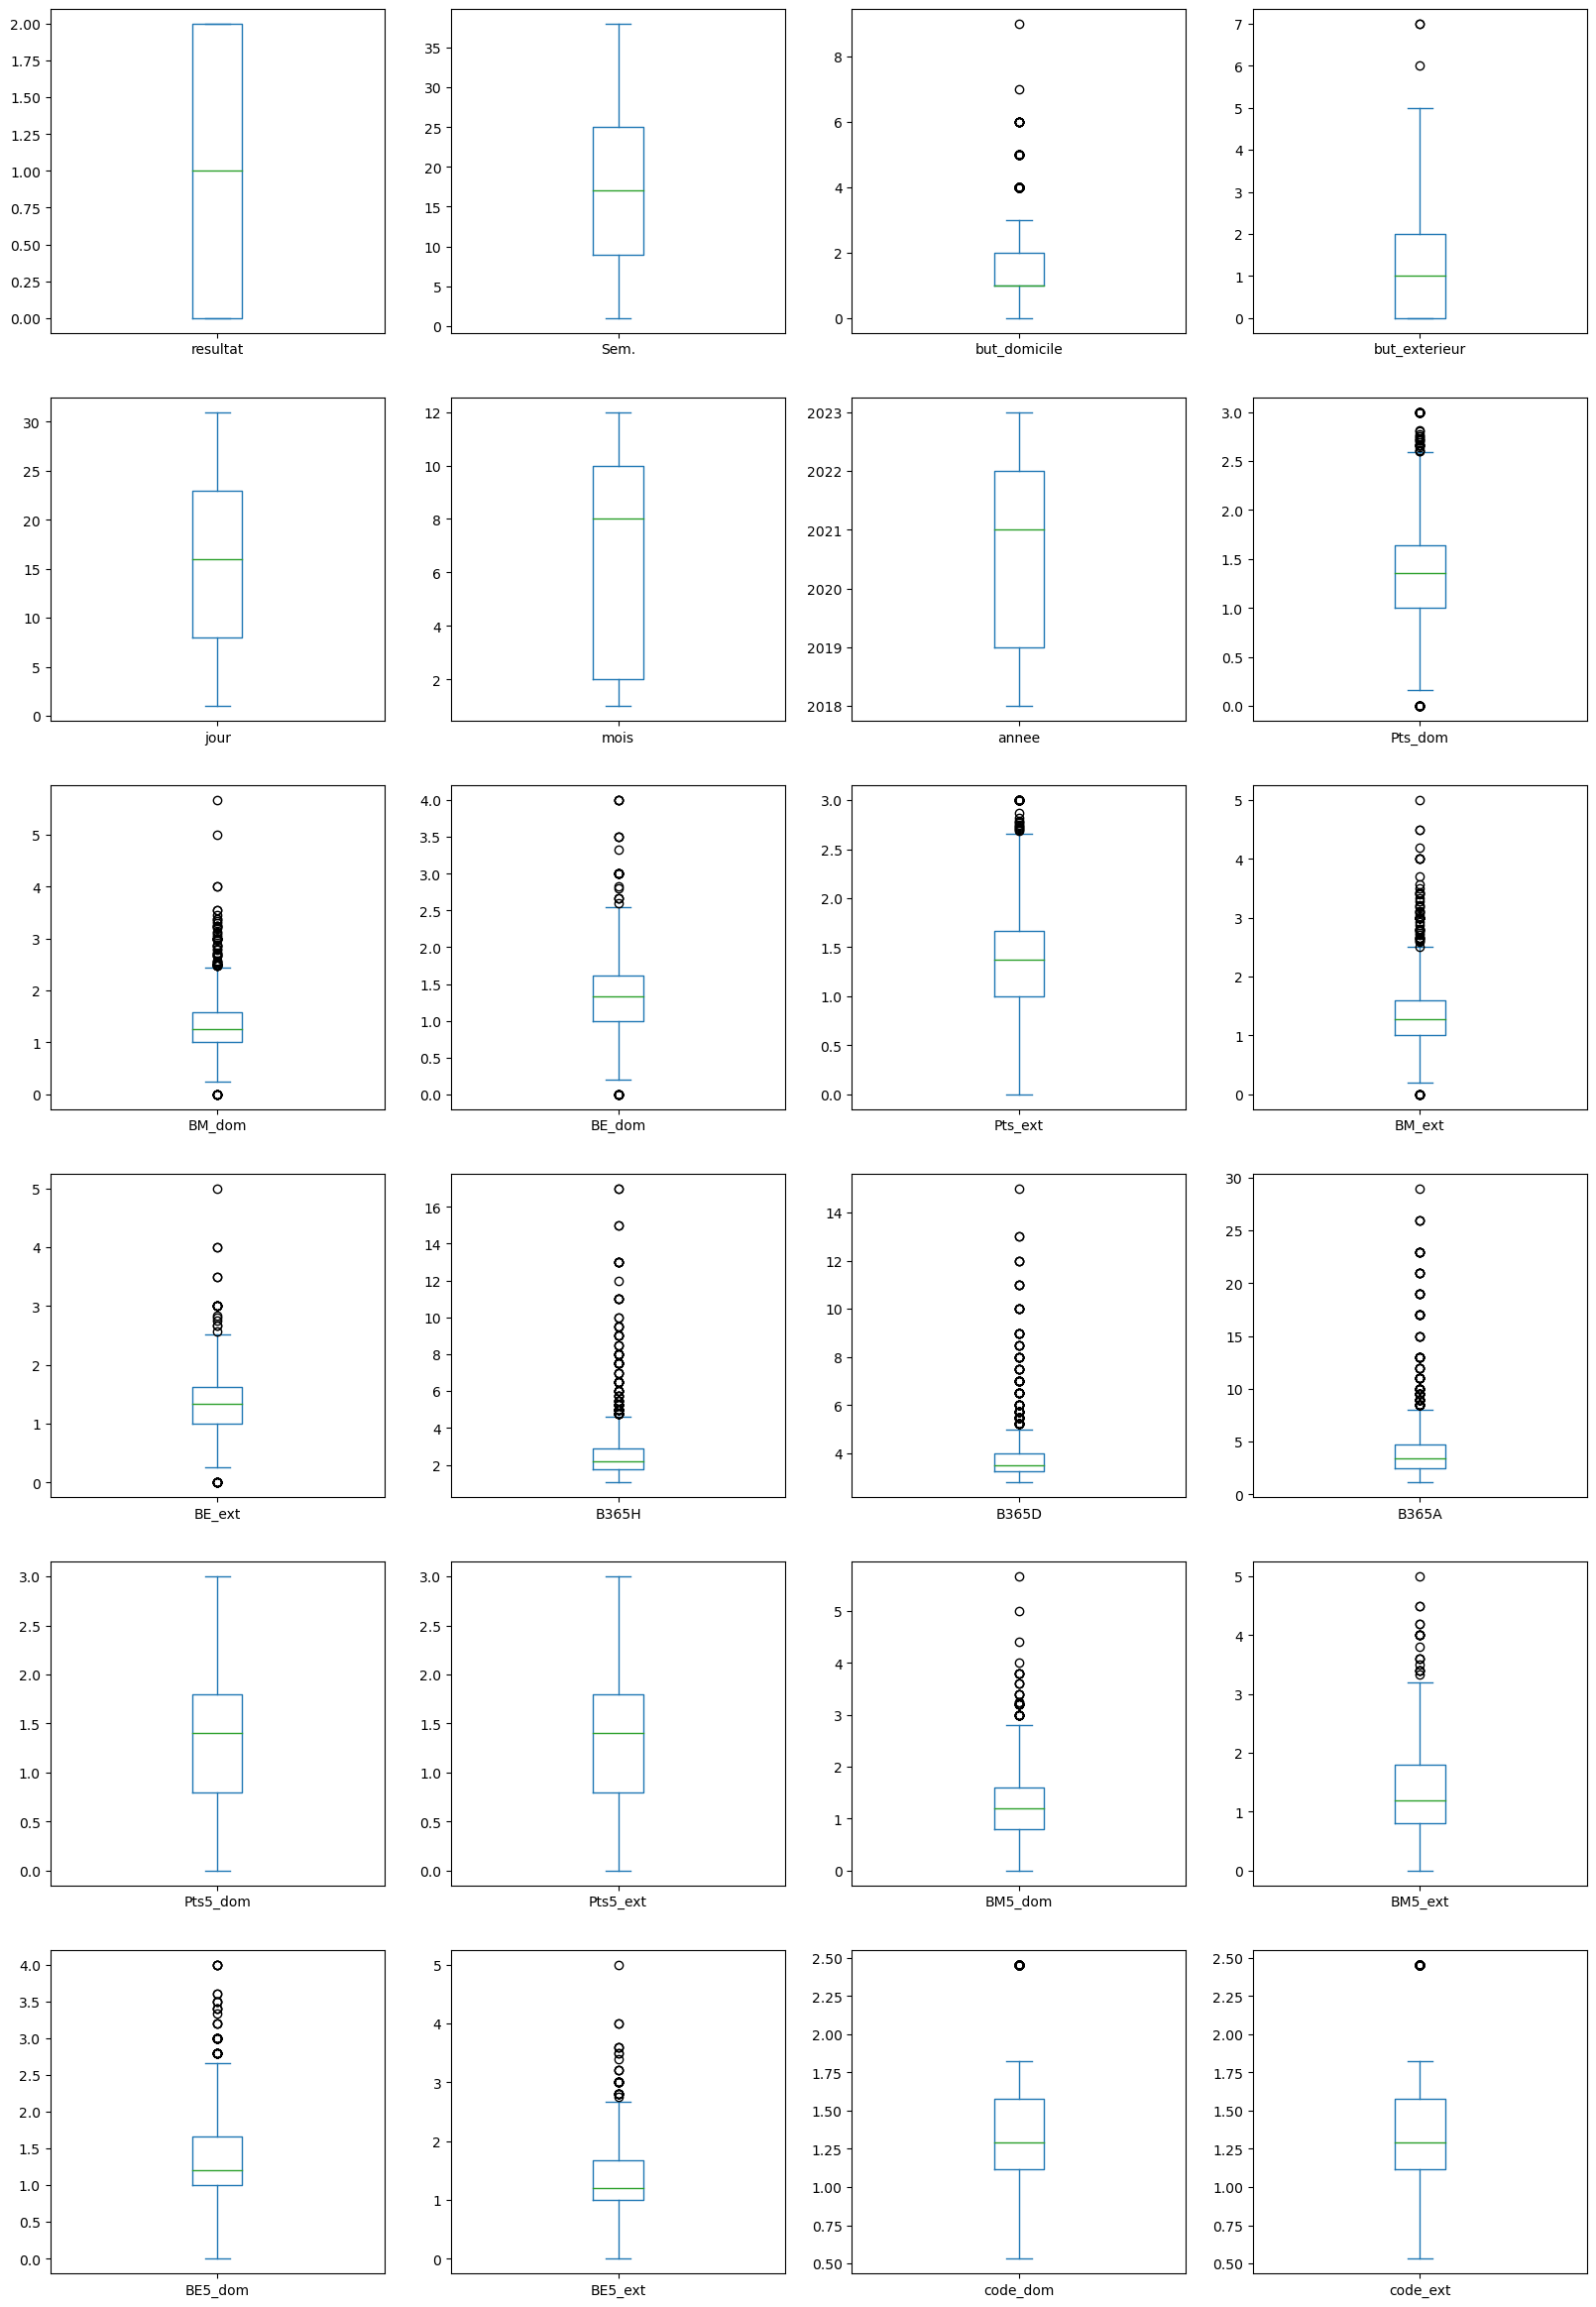

In [466]:
def boxPlotAll(df):
    '''Show box plots for each feature'''
    
    # Select just the numeric features
    df = df.select_dtypes(include=[np.number])

    # Compute the layout grid size
    data_cols = len(df.columns)
    unit_size = 5
    layout_cols = 4
    layout_rows = int(data_cols/layout_cols+layout_cols)

    # Make the plots
    df.plot(kind='box', subplots=True, figsize=(layout_cols*unit_size,layout_rows*unit_size), layout=(layout_rows,layout_cols))

    plt.show()   
boxPlotAll(matchs_joue_dom_ext)

Matrice de corelation des données

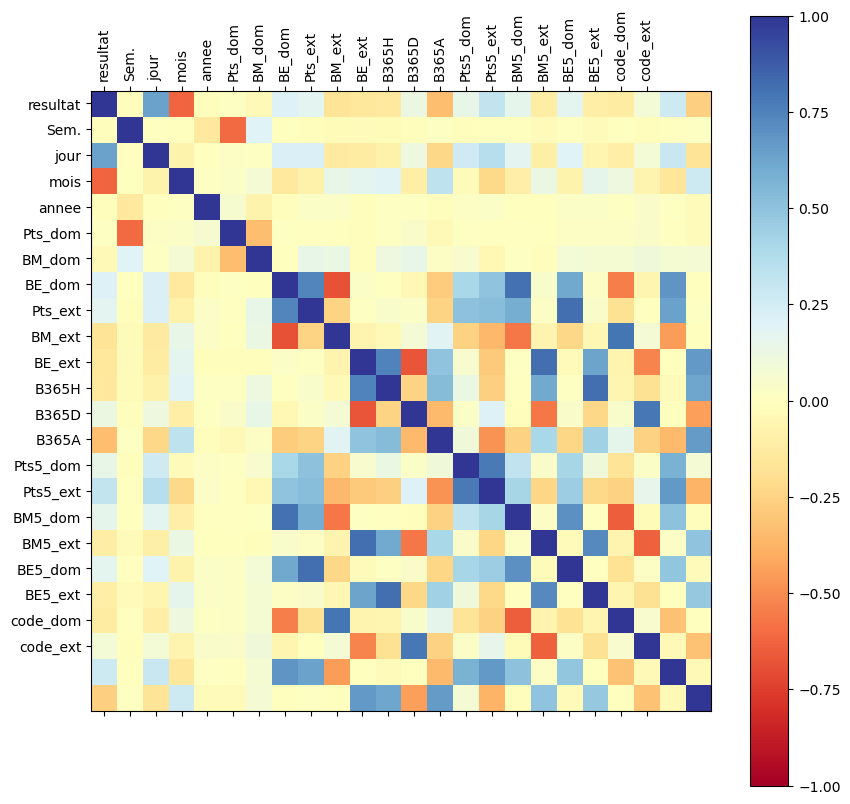

In [467]:
def correlationMatrix(df):
    '''Show a correlation matrix for all features.'''
    columns = df.select_dtypes(include=['float64','int64']).columns
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(df.corr(), vmin=-1, vmax=1, interpolation='none',cmap='RdYlBu')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(columns)))
    ax.set_yticks(np.arange(len(columns)))
    ax.set_xticklabels(columns, rotation = 90)
    ax.set_yticklabels(columns)
    plt.show()
correlationMatrix(matchs_joue_dom_ext)

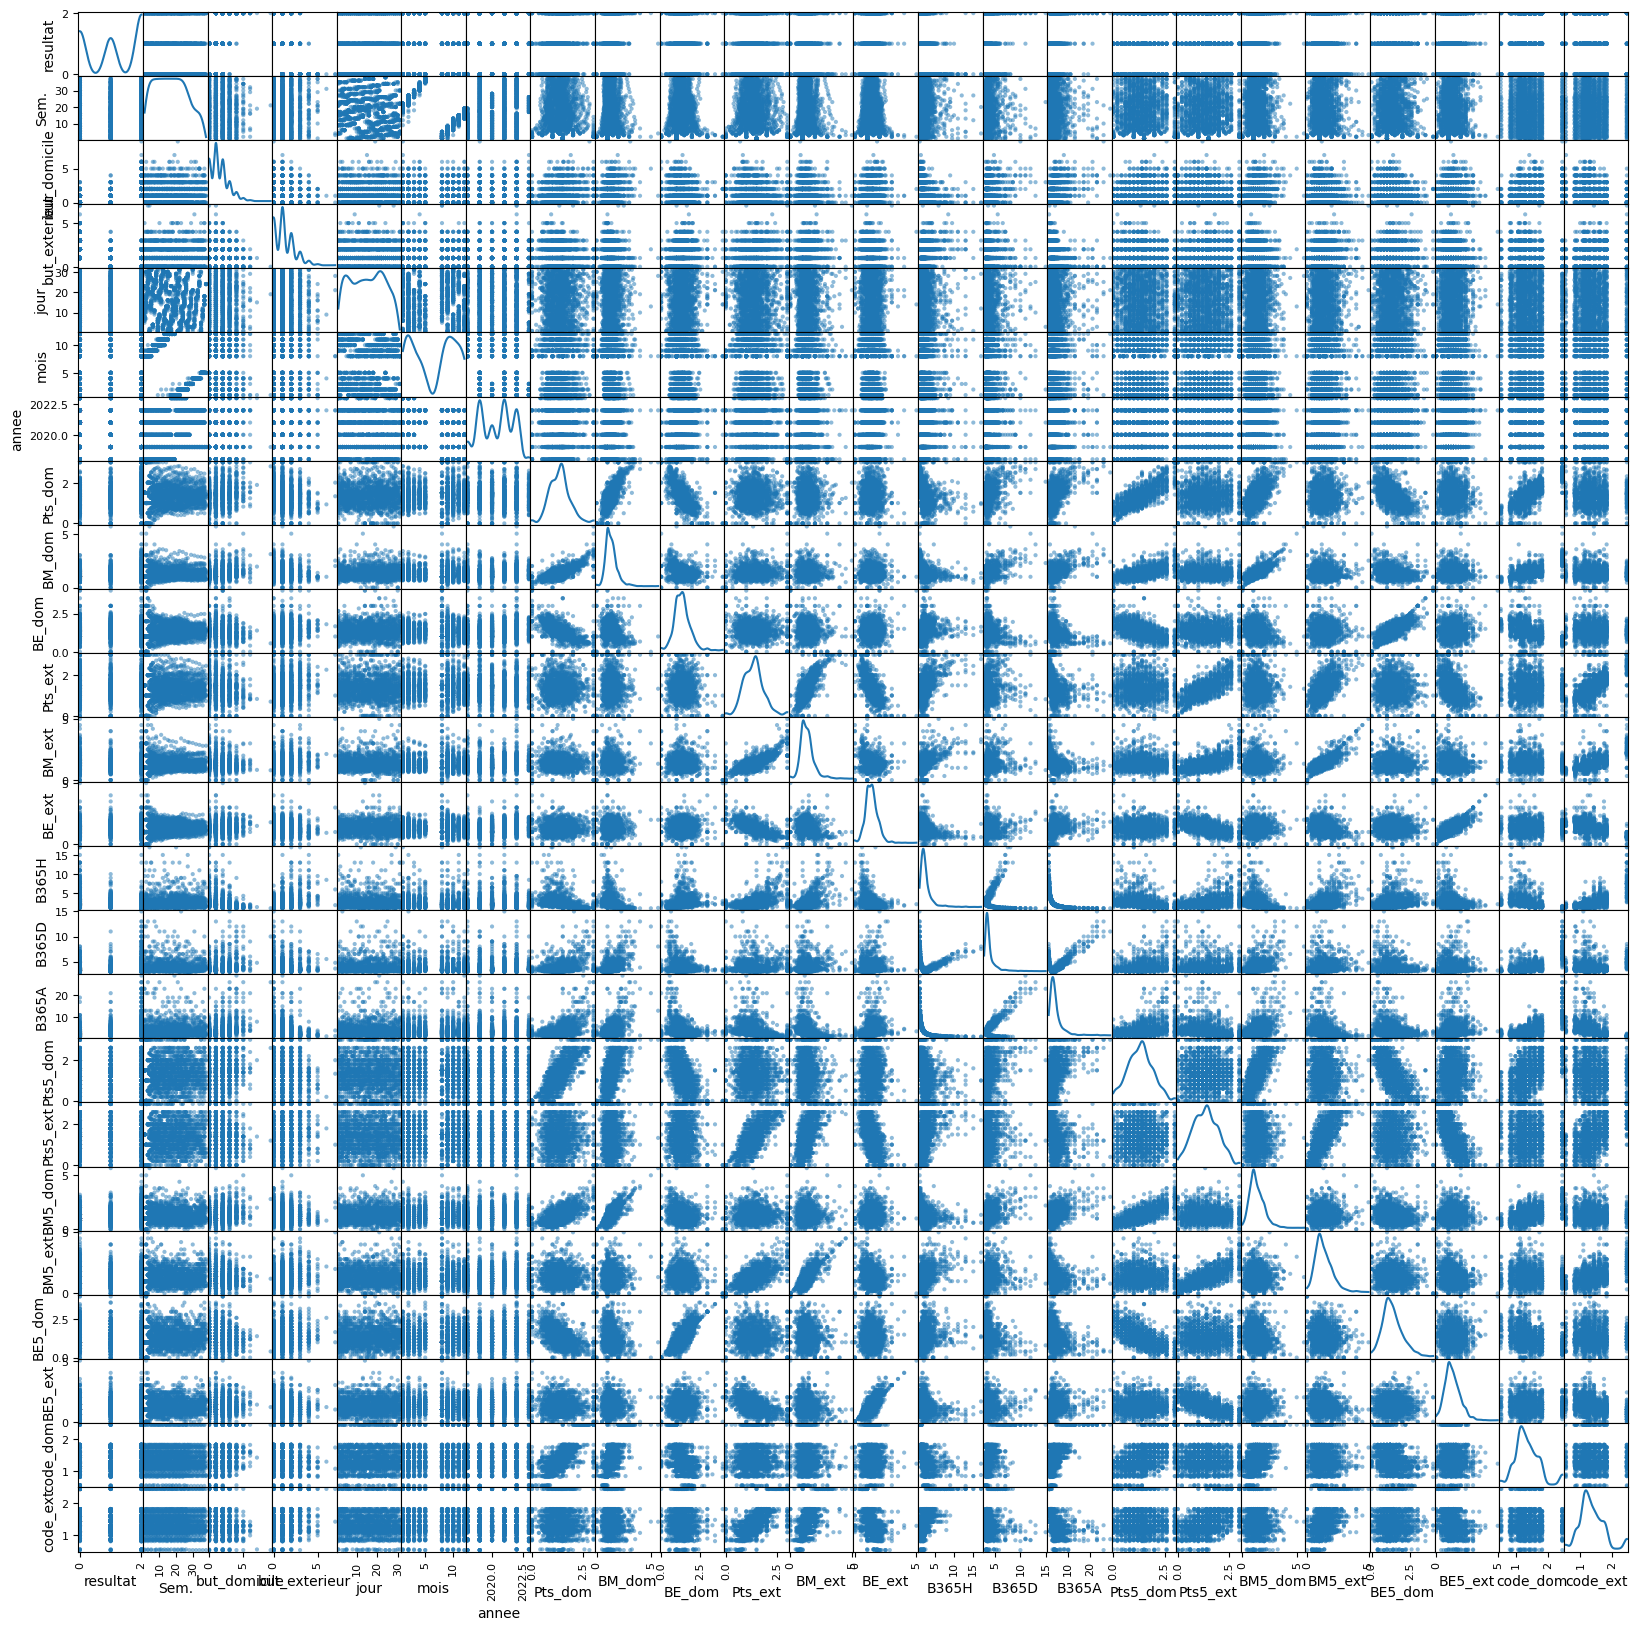

In [468]:
def scatterMatrix(df):
    '''Show a scatter matrix of all features.'''
    unit_size = 5
    pd.plotting.scatter_matrix(df,figsize=(unit_size*4, unit_size*4),  diagonal='kde')
    plt.show()
scatterMatrix(matchs_joue_dom_ext)

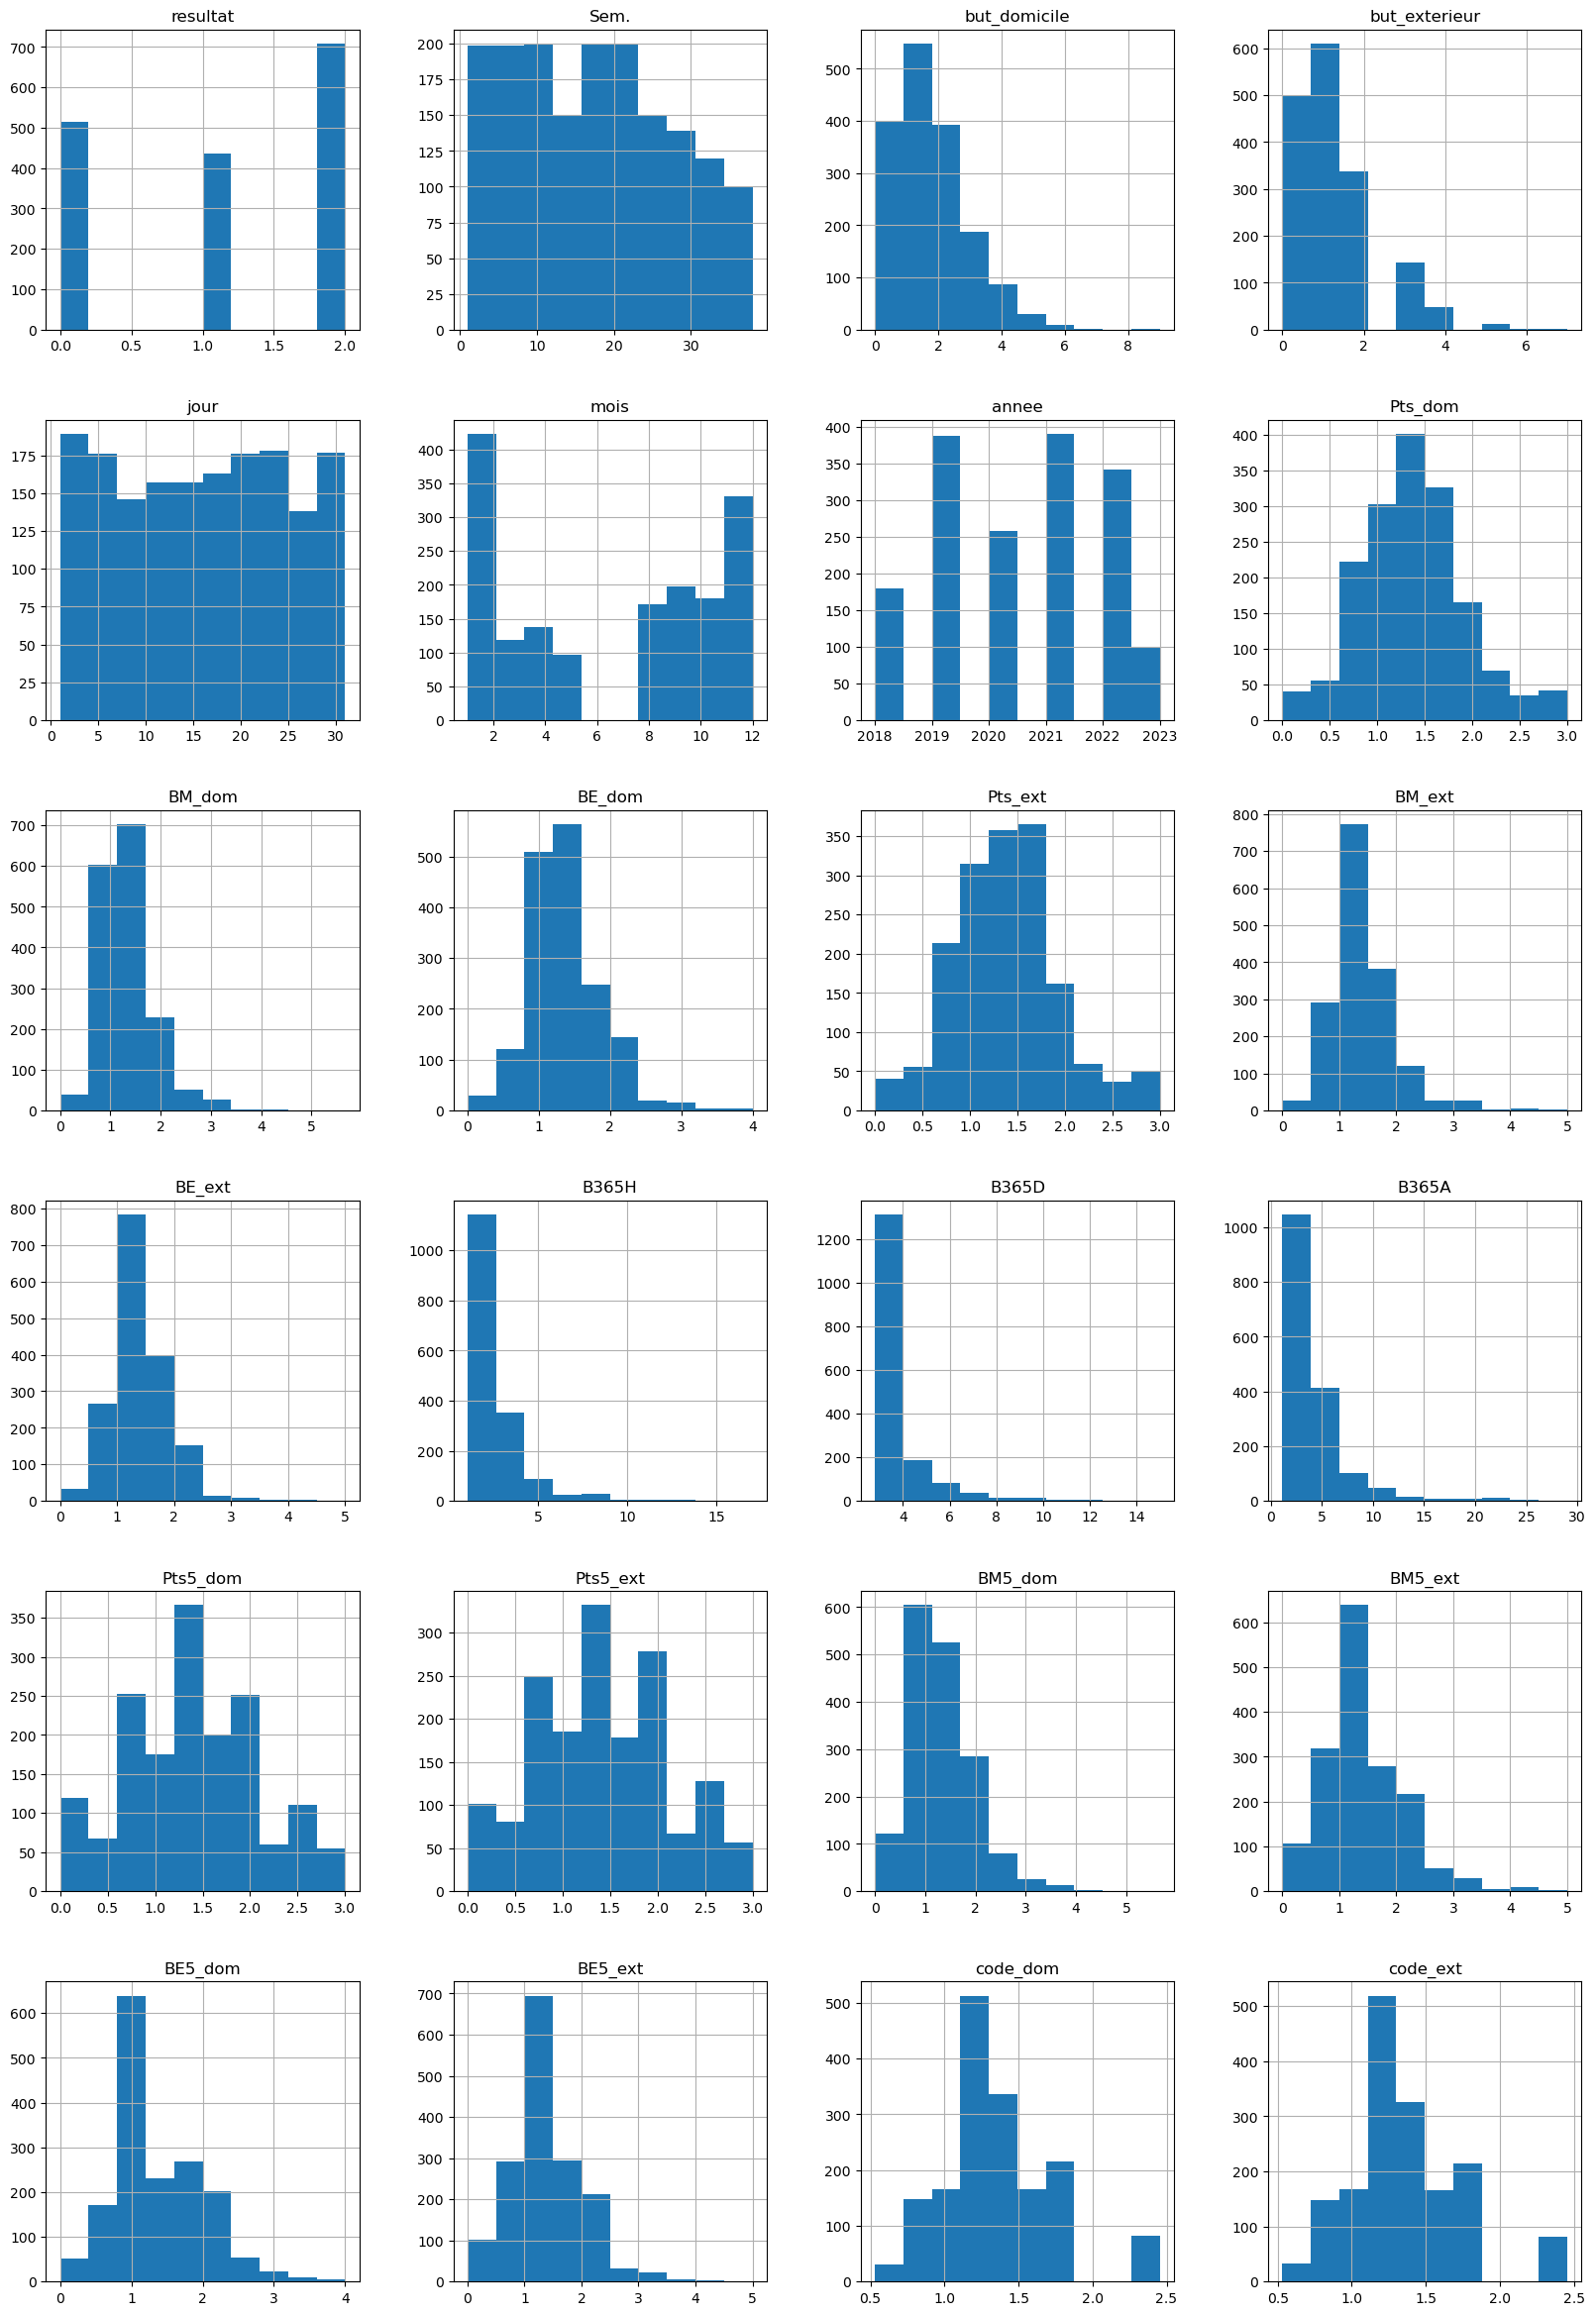

In [469]:
def histPlotAll(df):
    '''Show histograms for each feature'''

    # Select just the numeric features
    df = df.select_dtypes(include=[np.number])

    # Compute the layout grid size
    data_cols = len(df.columns)
    unit_size = 5
    layout_cols = 4
    layout_rows = int(data_cols/layout_cols+layout_cols)

    # Make the plots
    df.hist(figsize=(layout_cols*unit_size,layout_rows*unit_size), layout=(layout_rows,layout_cols))
            
    plt.show()
histPlotAll(matchs_joue_dom_ext)

On sépare les données pour créer les modèles

In [470]:
# On sépare les données en train et test
X = matchs_joue_dom_ext[["Pts_dom","Pts5_dom","BM_dom","BM_ext","BE_dom","BE_ext","BM5_dom","BM5_ext","BE5_dom","BE5_ext","Pts_ext","Pts5_ext","code_dom","code_ext"]]
y = matchs_joue_dom_ext[['resultat',"B365H","B365D","B365A"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Création du modèle décision tree

In [471]:
# Build a decision tree model
mode_dt = DecisionTreeClassifier(max_depth=5)
mode_dt.fit(X_train,y_train["resultat"])
# Afficher l'arbre de décision
#print("décision_tree pour écart de but \n",export_text(mode1_dt, feature_names=list(X_train)))
# Check the model performance with the training data
predictions_dt_train = mode_dt.predict(X_train)
print("prediction avec les training data:",accuracy_score(y_train["resultat"], predictions_dt_train))
# Check the model performance with the test data
predictions_dt_test = mode_dt.predict(X_test)
print("prediction avec les test data:",accuracy_score(y_test["resultat"], predictions_dt_test))

prediction avec les training data: 0.5471698113207547
prediction avec les test data: 0.48493975903614456


In [472]:
somme_bet = 0
for i in range(len(y_test)):
    if y_test.iloc[i,1] == 0:
        compteur_na += 1
    else:
        if y_test.iloc[i,0] == predictions_dt_test[i]:
            if y_test.iloc[i,0] == 2:
                somme_bet += y_test.iloc[i,1]
            elif y_test.iloc[i,0] == 1:
                somme_bet += y_test.iloc[i,2]
            elif y_test.iloc[i,0] == 0:
                somme_bet += y_test.iloc[i,3]
somme_bet = ((somme_bet-len(y_test))/(len(y_test)))*100
print(somme_bet)

2.56325301204819


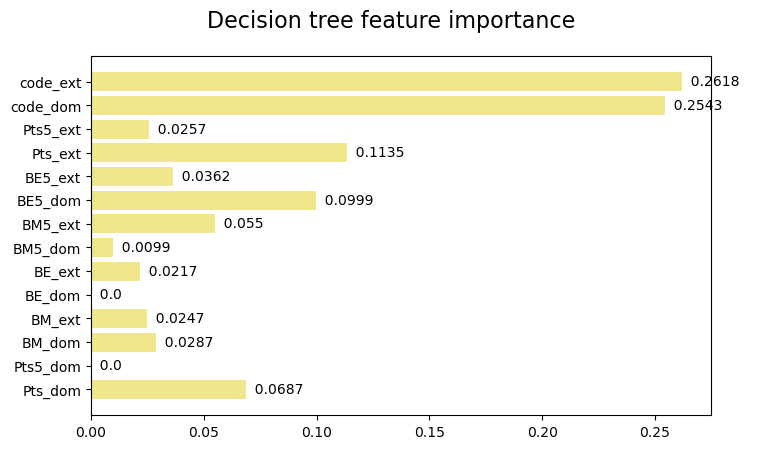

In [473]:
def decisionTreeSummary(model, column_names):
    '''Show a summary of the trained decision tree model'''

    # Plot the feature importances as bars
    fig = plt.figure(figsize=(8,len(column_names)/3))
    fig.suptitle('Decision tree feature importance', fontsize=16)
    rects = plt.barh(column_names, model.feature_importances_,color="khaki")

    # Annotate the bars with the feature importance values
    for rect in rects:
        width = round(rect.get_width(),4)
        plt.gca().annotate('  {}  '.format(width),
                    xy=(width, rect.get_y()),
                    xytext=(0,2),  
                    textcoords="offset points",  
                    ha='left', va='bottom')    

    plt.show()
decisionTreeSummary(mode_dt, X_train.columns)

Prévision des résultats decision tree

In [475]:
matchs_a_joue_dom_ext["resultat"] = mode_dt.predict(matchs_a_joue_dom_ext[["Pts_dom","Pts5_dom","BM_dom","BM_ext","BE_dom","BE_ext","BM5_dom","BM5_ext","BE5_dom","BE5_ext","Pts_ext","Pts5_ext","code_dom","code_ext"]])
resultat_mode_dt = matchs_a_joue_dom_ext[['Domicile',"Extérieur","resultat"]]
resultat_mode_dt.head(10)

,Domicile,Extérieur,resultat
0,Clermont Foot,Lens,0
1,Lorient,Troyes,2
2,Ajaccio,Montpellier,1
3,Nantes,Nice,1
4,Angers,Toulouse,2
5,Monaco,Reims,2
6,Marseille,Strasbourg,2
7,Lyon,Nantes,2
8,Toulouse,Lille,0
9,Lens,Angers,2


Modele logistic regression nombre de but

In [476]:
# Buill a logistic regression model for the ecart de but
mode_lr = LogisticRegression(solver = 'liblinear', max_iter=1000, multi_class='ovr')
mode_lr.fit(X_train, y_train["resultat"])
# Check the model performance with the training data
predictions_lr_train = mode_lr.predict(X_train)
print("prediction avec les training data:",accuracy_score(y_train["resultat"], predictions_lr_train))
# Check the model performance with the test data
predictions_lr_test = mode_lr.predict(X_test)
print("prediction avec les test data:",accuracy_score(y_test["resultat"], predictions_lr_test))

prediction avec les training data: 0.5116981132075472
prediction avec les test data: 0.5090361445783133


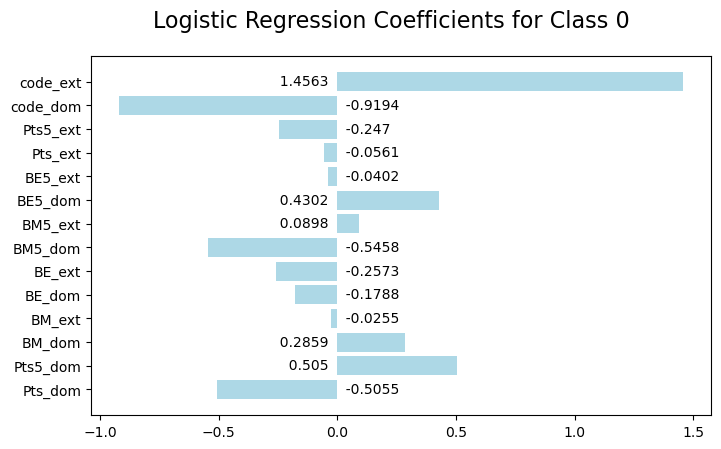

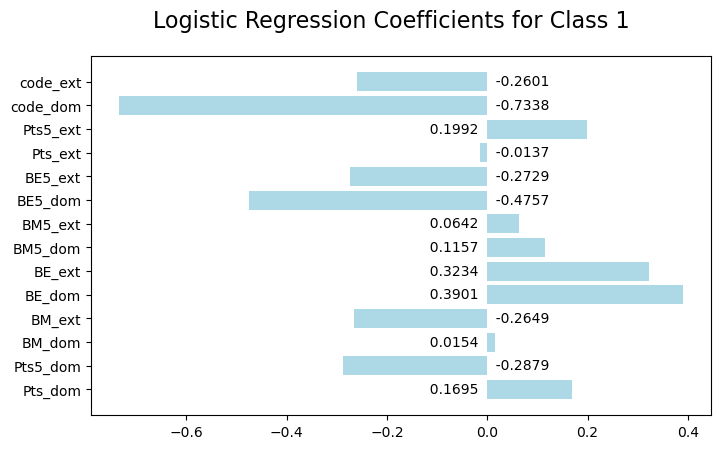

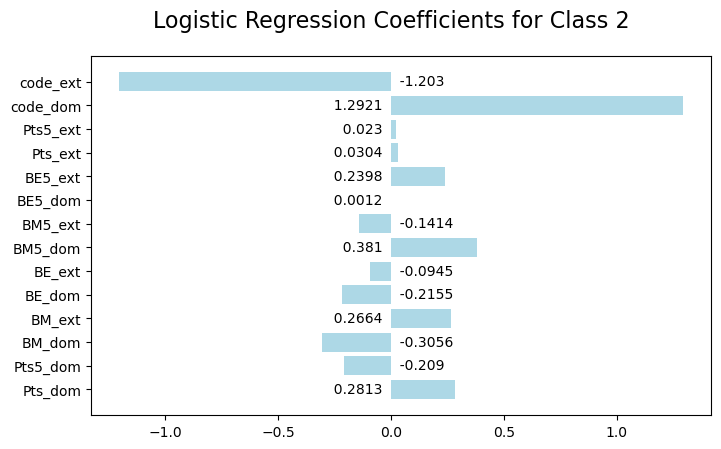

In [477]:
def logisticRegressionSummary(model, column_names):
    '''Show a summary of the trained logistic regression model'''

    # Get a list of class names
    numclasses = len(model.classes_)
    if len(model.classes_)==2:
        classes =  [model.classes_[1]] # if we have 2 classes, sklearn only shows one set of coefficients
    else:
        classes = model.classes_

    # Create a plot for each class
    for i,c in enumerate(classes):
        # Plot the coefficients as bars
        fig = plt.figure(figsize=(8,len(column_names)/3))
        fig.suptitle('Logistic Regression Coefficients for Class ' + str(c), fontsize=16)
        rects = plt.barh(column_names, model.coef_[i],color="lightblue")
        
        # Annotate the bars with the coefficient values
        for rect in rects:
            width = round(rect.get_width(),4)
            plt.gca().annotate('  {}  '.format(width),
                        xy=(0, rect.get_y()),
                        xytext=(0,2),  
                        textcoords="offset points",  
                        ha='left' if width<0 else 'right', va='bottom')        
        plt.show()
logisticRegressionSummary(mode_lr, X_train.columns)

In [478]:
somme_bet = 0
for i in range(len(y_test)):
    if y_test.iloc[i,0] == predictions_lr_test[i]:
        if y_test.iloc[i,0] == 2:
            somme_bet += y_test.iloc[i,1]
        elif y_test.iloc[i,0] == 1:
            somme_bet += y_test.iloc[i,2]
        elif y_test.iloc[i,0] == 0:
            somme_bet += y_test.iloc[i,3]
somme_bet = ((somme_bet-len(y_test))/len(y_test))*100
print(somme_bet)

-1.207831325301185


Prévision des résultat logistic regression


In [479]:
matchs_a_joue_dom_ext["resultat"] = mode_lr.predict(matchs_a_joue_dom_ext[['Pts_dom','Pts5_dom','BM_dom','BM_ext','BE_dom','BE_ext','BM5_dom','BM5_ext','BE5_dom','BE5_ext','Pts_ext','Pts5_ext','code_dom','code_ext']])
resultat_mode_lr = matchs_a_joue_dom_ext[['Domicile',"Extérieur","resultat"]]
resultat_mode_lr.head(10)

,Domicile,Extérieur,resultat
0,Clermont Foot,Lens,0
1,Lorient,Troyes,2
2,Ajaccio,Montpellier,0
3,Nantes,Nice,0
4,Angers,Toulouse,2
5,Monaco,Reims,2
6,Marseille,Strasbourg,2
7,Lyon,Nantes,2
8,Toulouse,Lille,0
9,Lens,Angers,2


Creation de tous les modèles en une boucle

In [480]:
mode_dt = DecisionTreeClassifier(max_depth=5)
mode_lr = LogisticRegression(solver = 'liblinear', max_iter=1000, multi_class='ovr')
mode_bayes = GaussianNB()
mode_multi = MultinomialNB()
mode_knn = KNeighborsClassifier(n_neighbors=5,weights='distance')
mode_svm = svm.SVC(kernel= "rbf", C=1.0, probability=True,decision_function_shape='ovo',gamma='auto')
mode_rf = RandomForestClassifier(n_estimators=1000, max_depth=3,random_state=0, n_jobs=-1)
mode_xgb = GradientBoostingClassifier(loss = "deviance")
mode_rna = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1, max_iter=1000)
modes = [mode_dt, mode_lr, mode_bayes, mode_multi, mode_knn, mode_svm, mode_rf, mode_xgb, mode_rna]
modes_names = ["Decision Tree", "Logistic Regression", "Naive Bayes", "Multinomial Naive Bayes", "KNN", "SVM", "Random Forest", "XGBoost", "RNA"]
accuracy_score_test_data = []
accuracy_score_train_data = []
predictions_test_data = []
predictions_train_data = []
somme_bets = []
for mode in modes:
    mode.fit(X_train, y_train["resultat"])
    # Check the model performance with the training data
    predictions_train_data.append(mode.predict(X_train))
    accuracy_score_train_data.append (100*accuracy_score(y_train["resultat"], predictions_train_data[-1]))
    # Check the model performance with the test data
    predictions_test_data.append(mode.predict(X_test))
    accuracy_score_test_data.append(100*accuracy_score(y_test["resultat"], predictions_test_data[-1]))
    somme_bet = 0
    for i in range(len(y_test)):
        if y_test.iloc[i,0] == predictions_test_data[-1][i]:
            if y_test.iloc[i,0] == 2:
                somme_bet += y_test.iloc[i,1]
            elif y_test.iloc[i,0] == 1:
                somme_bet += y_test.iloc[i,2]
            elif y_test.iloc[i,0] == 0:
                somme_bet += y_test.iloc[i,3]
    somme_bet = ((somme_bet-len(y_test))/len(y_test))*100
    somme_bets.append(somme_bet)
df = pd.DataFrame(zip(modes_names,accuracy_score_train_data, accuracy_score_test_data, somme_bets), columns =['Modele', 'Accuracy score train data (%)', 'Accuracy score test data (%)', 'Somme des paris (%)'])
df



c:\Users\jules\miniconda3\envs\myenv\lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


,Modele,Accuracy score train data (%),Accuracy score test data (%),Somme des paris (%)
0,Decision Tree,54.716981,48.192771,2.075301
1,Logistic Regression,51.169811,50.903614,-1.207831
2,Naive Bayes,47.018868,49.397590,4.036145
3,Multinomial Naive Bayes,48.981132,48.192771,-8.379518
4,KNN,99.849057,43.975904,0.969880
5,SVM,51.471698,51.204819,-1.924699
6,Random Forest,52.377358,50.000000,-5.343373
7,XGBoost,78.339623,53.614458,12.563253
8,RNA,50.641509,52.409639,3.533133
